=== ИНФОРМАЦИЯ О ДАННЫХ ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2111 entries, 0 to 2110
Data columns (total 17 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Gender                          2111 non-null   object 
 1   Age                             2111 non-null   float64
 2   Height                          2111 non-null   float64
 3   Weight                          2111 non-null   float64
 4   family_history_with_overweight  2111 non-null   object 
 5   FAVC                            2111 non-null   object 
 6   FCVC                            2111 non-null   float64
 7   NCP                             2111 non-null   float64
 8   CAEC                            2111 non-null   object 
 9   SMOKE                           2111 non-null   object 
 10  CH2O                            2111 non-null   float64
 11  SCC                             2111 non-null   object 
 12  FAF   

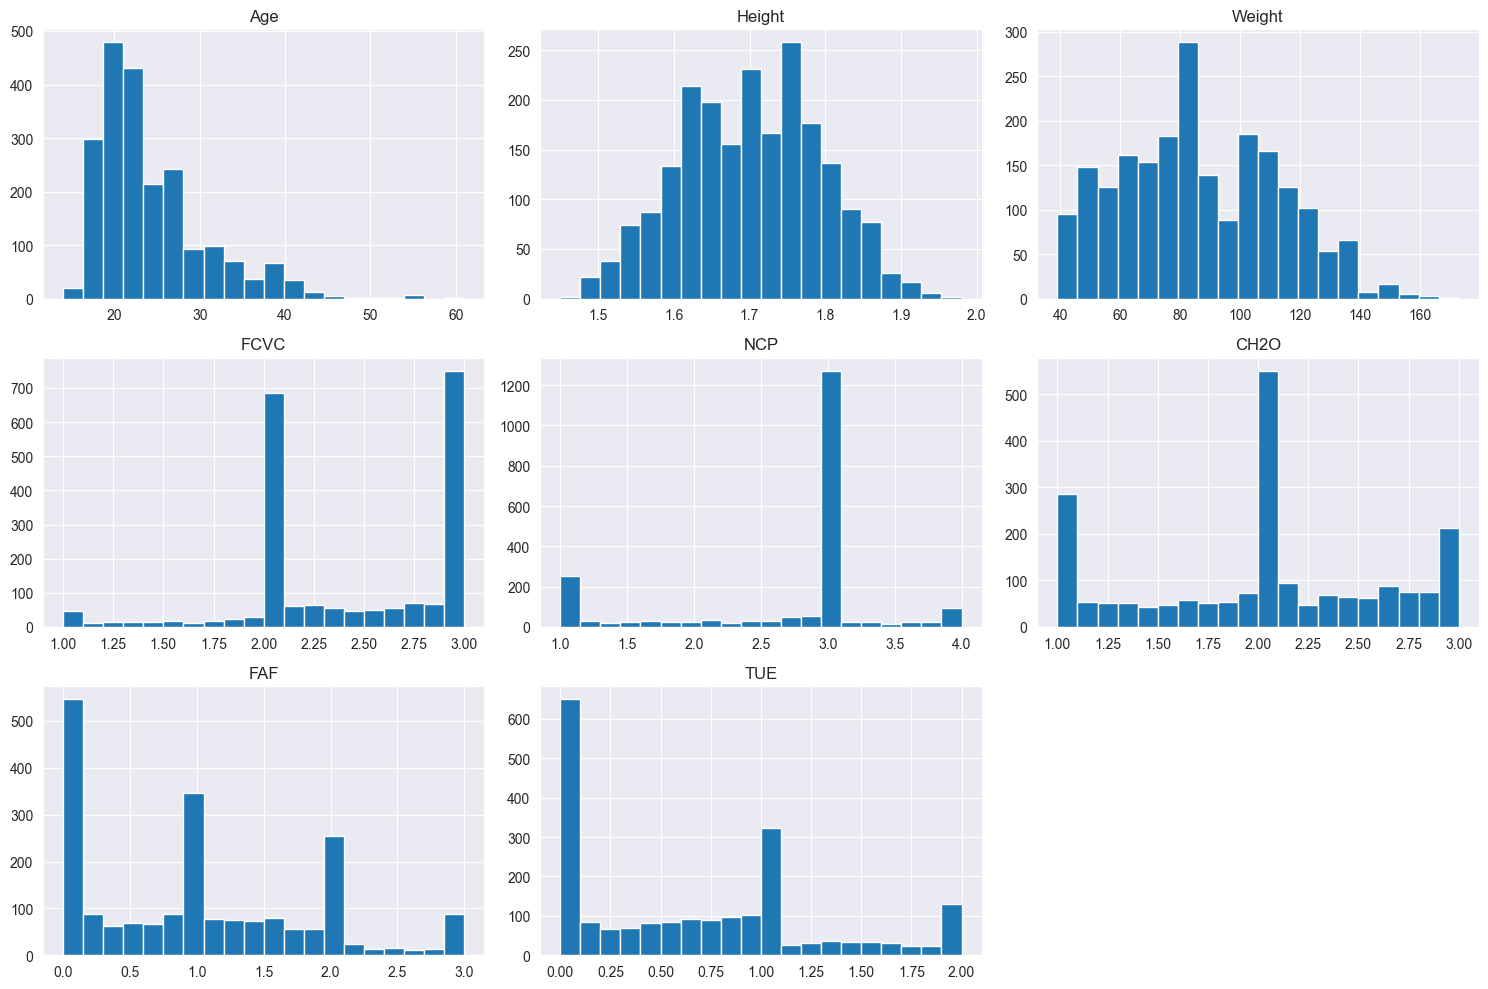

Значения ДО округления:
FCVC: [np.int64(1), np.int64(2), np.int64(3)]
NCP: [np.int64(1), np.int64(2), np.int64(3), np.int64(4)]
CH2O: [np.int64(1), np.int64(2), np.int64(3)]
FAF: [np.int64(0), np.int64(1), np.int64(2), np.int64(3)]
TUE: [np.int64(0), np.int64(1), np.int64(2)]

Значения ПОСЛЕ округления:
FCVC: [np.int64(1), np.int64(2), np.int64(3)]
NCP: [np.int64(1), np.int64(2), np.int64(3), np.int64(4)]
CH2O: [np.int64(1), np.int64(2), np.int64(3)]
FAF: [np.int64(0), np.int64(1), np.int64(2), np.int64(3)]
TUE: [np.int64(0), np.int64(1), np.int64(2)]

=== ДАННЫЕ ПОСЛЕ ПРЕОБРАЗОВАНИЯ ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2111 entries, 0 to 2110
Data columns (total 18 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Gender                          2111 non-null   int64  
 1   Age                             2111 non-null   float64
 2   Height                          2111 non-null   f

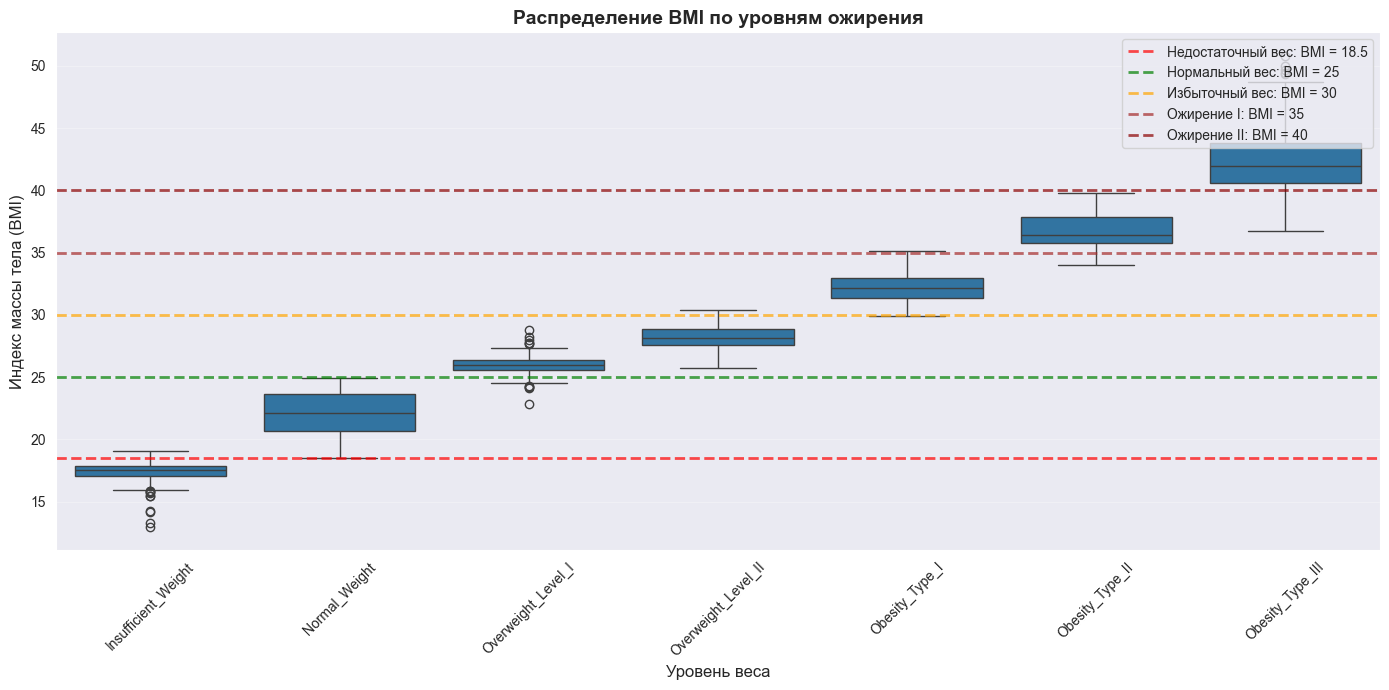

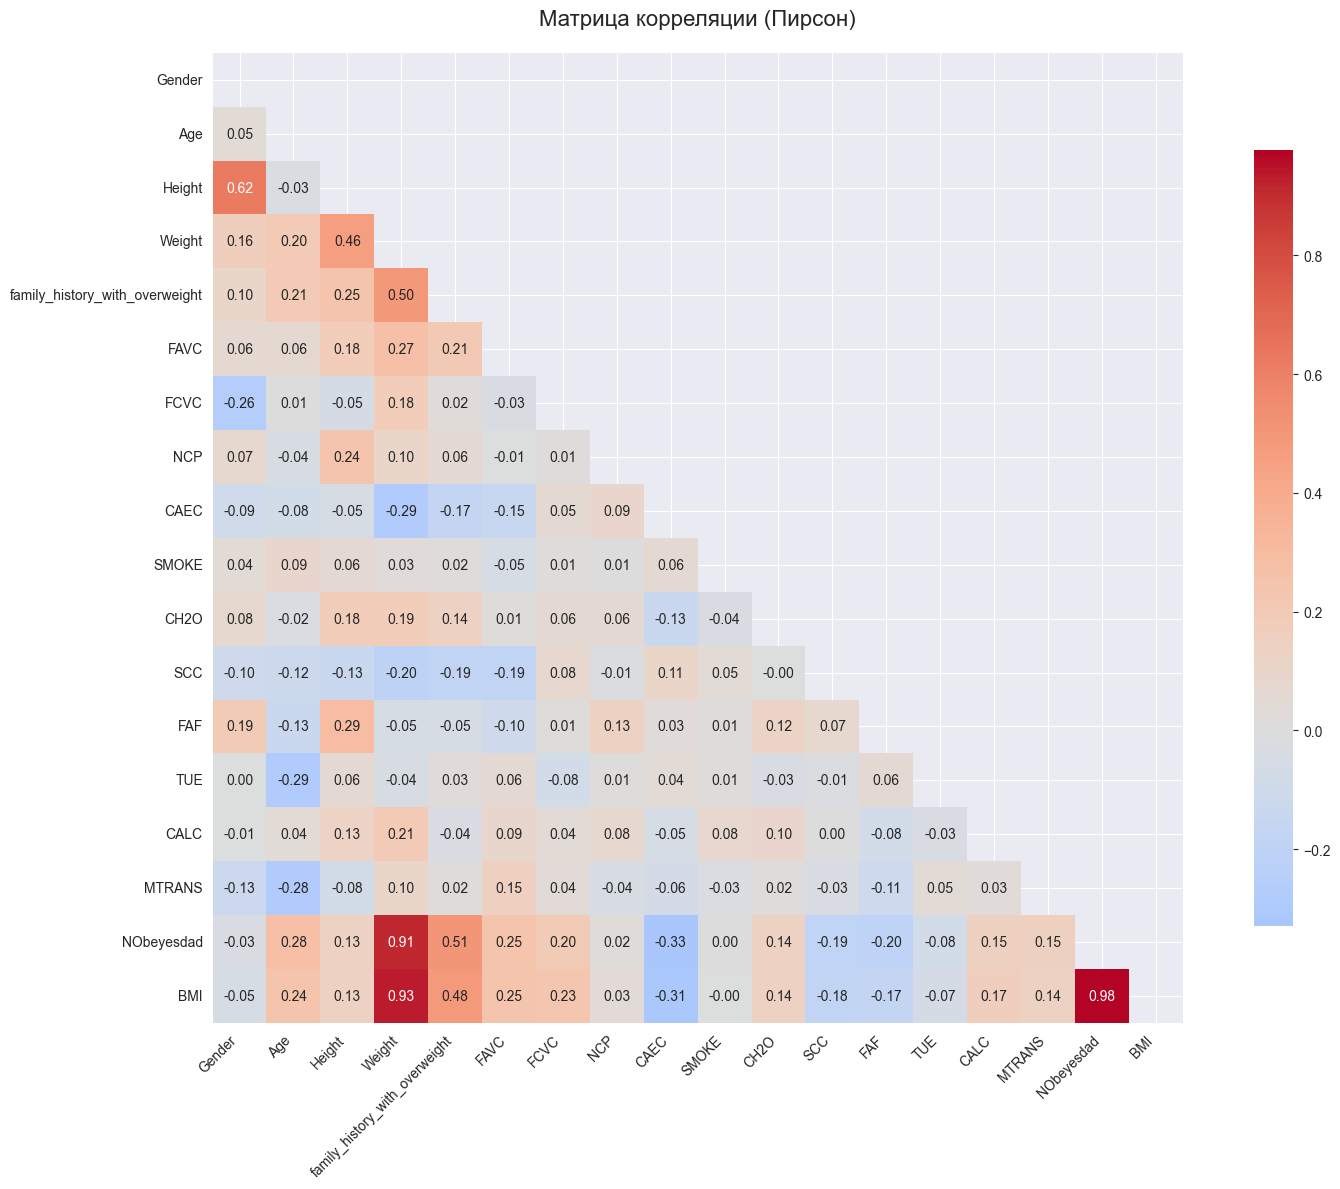

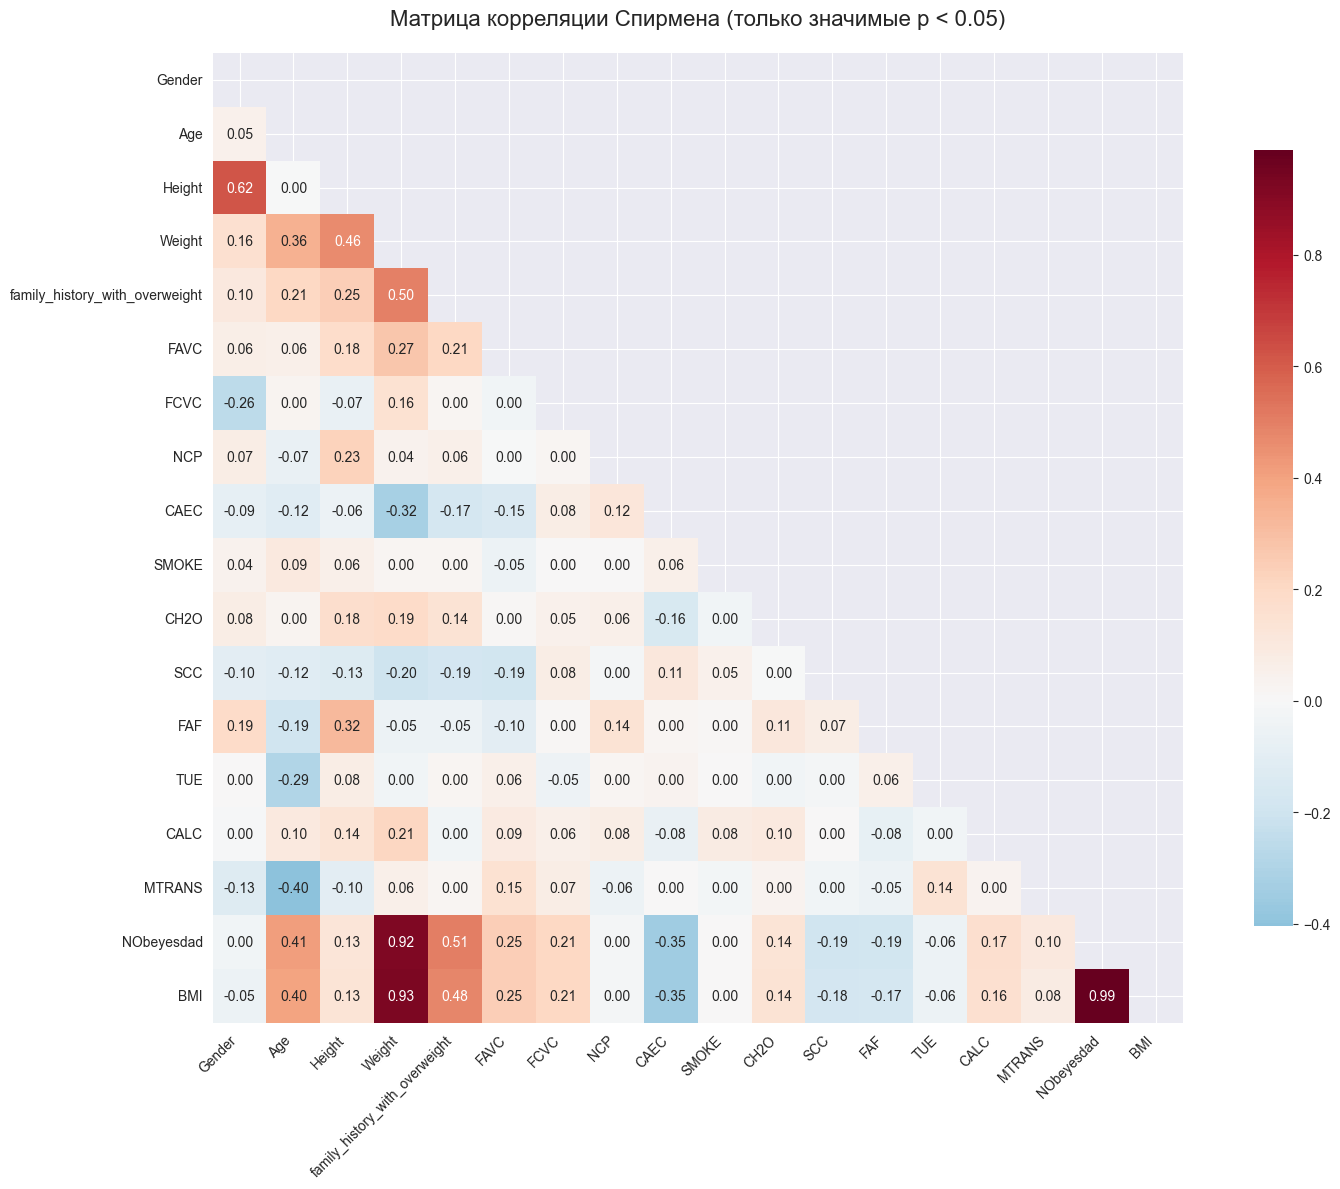

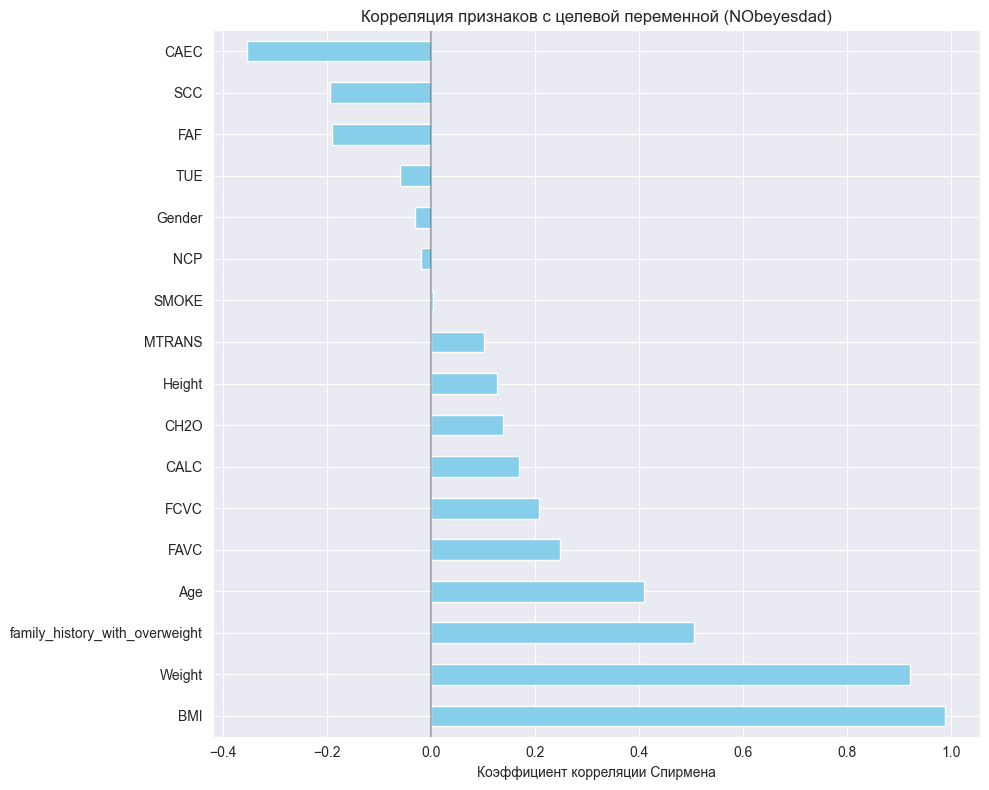

Топ положительных корреляций с ожирением:
NObeyesdad                        1.000000
BMI                               0.988010
Weight                            0.921320
family_history_with_overweight    0.505148
Age                               0.408760
FAVC                              0.247793
FCVC                              0.207816
CALC                              0.168379
CH2O                              0.137553
Height                            0.126830
Name: NObeyesdad, dtype: float64

Топ отрицательных корреляций с ожирением:
NCP      -0.018456
Gender   -0.031464
TUE      -0.059823
FAF      -0.190270
SCC      -0.194508
CAEC     -0.352752
Name: NObeyesdad, dtype: float64


In [75]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression, ElasticNet, LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, OrdinalEncoder, OneHotEncoder
from sklearn.metrics import r2_score, classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import cross_val_score, cross_validate, KFold, train_test_split, GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from scipy.stats import spearmanr, pointbiserialr
import scipy.stats as stats

# Загрузка данных
df = pd.read_csv('C:/Education/Project/ObesityDataSet.csv', sep=',')

print("=== ИНФОРМАЦИЯ О ДАННЫХ ===")
print(df.info())
print("\n=== УНИКАЛЬНЫЕ ЗНАЧЕНИЯ (до обработки) ===")
for column in df.columns:
    unique_count = df[column].nunique()
    print(f"{column}: {unique_count} уникальных значений")
    if unique_count <= 10:
        print(f"   Значения: {df[column].unique()}")

df.hist(figsize=(15, 10), bins=20)
plt.tight_layout()
plt.show()

categorical_numeric_features = ['FCVC', 'NCP', 'CH2O', 'FAF', 'TUE']
for col in categorical_numeric_features:
    df[col] = df[col].round().astype(int)

print("Значения ДО округления:")
for col in categorical_numeric_features:
    print(f"{col}: {sorted(df[col].unique())}")

# Округляем каждую колонку до целого числа
for col in categorical_numeric_features:
    df[col] = df[col].round().astype(int)

print("\nЗначения ПОСЛЕ округления:")
for col in categorical_numeric_features:
    print(f"{col}: {sorted(df[col].unique())}")

binary_columns = ['Gender', 'family_history_with_overweight', 'FAVC', 'SMOKE', 'SCC']
binary_mapping = {'no': 0, 'yes': 1, 'Female': 0, 'Male': 1}
for col in binary_columns:
    if col in df.columns:
        df[col] = df[col].map(binary_mapping)

ordinal_mappings = {
    'FCVC': {1: 1, 2: 2, 3: 3},
    'NCP': {1: 1, 2: 2, 3: 3, 4: 4},
    'CAEC': {'no': 0, 'Sometimes': 1, 'Frequently': 2, 'Always': 3},
    'CH2O': {1: 1, 2: 2, 3: 3},
    'FAF': {0: 0, 1: 1, 2: 2, 3: 3},
    'TUE': {0: 0, 1: 1, 2: 2},
    'CALC': {'no': 0, 'Sometimes': 1, 'Frequently': 2, 'Always': 3},
    'MTRANS': {'Walking': 1, 'Bike': 2, 'Motorbike': 3, 'Automobile': 4, 'Public_Transportation': 5}
}

for col, mapping in ordinal_mappings.items():
    if col in df.columns:
        df[col] = df[col].map(mapping)

# Целевая переменная
obesity_order = {
    'Insufficient_Weight': 0,
    'Normal_Weight': 1,
    'Overweight_Level_I': 2,
    'Overweight_Level_II': 3,
    'Obesity_Type_I': 4,
    'Obesity_Type_II': 5,
    'Obesity_Type_III': 6
}
df['NObeyesdad'] = df['NObeyesdad'].map(obesity_order)

df['BMI'] = df['Weight'] / (df['Height'] ** 2)

print("\n=== ДАННЫЕ ПОСЛЕ ПРЕОБРАЗОВАНИЯ ===")
print(df.info())

obesity_mapping = {v: k for k, v in obesity_order.items()}
df['NObeyesdad_text'] = df['NObeyesdad'].map(obesity_mapping)

obesity_order_list = [
    'Insufficient_Weight', 'Normal_Weight', 'Overweight_Level_I',
    'Overweight_Level_II', 'Obesity_Type_I', 'Obesity_Type_II', 'Obesity_Type_III'
]

plt.figure(figsize=(14, 7))
sns.boxplot(data=df, x='NObeyesdad_text', y='BMI', order=obesity_order_list)
plt.xticks(rotation=45)
plt.title('Распределение BMI по уровням ожирения', fontsize=14, fontweight='bold')

bmi_boundaries = {'Недостаточный вес': 18.5, 'Нормальный вес': 25, 'Избыточный вес': 30,
                  'Ожирение I': 35, 'Ожирение II': 40}
colors = ['red', 'green', 'orange', 'brown', 'darkred']

for i, ((label, value), color) in enumerate(zip(bmi_boundaries.items(), colors)):
    plt.axhline(y=value, color=color, linestyle='--', alpha=0.7, linewidth=2,
                label=f'{label}: BMI = {value}')

plt.legend(loc='upper right')
plt.xlabel('Уровень веса', fontsize=12)
plt.ylabel('Индекс массы тела (BMI)', fontsize=12)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# Строим матрицу корреляции
plt.figure(figsize=(16, 12))
correlation_matrix = df.select_dtypes(include=[np.number]).corr()

# Визуализируем тепловую карту
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))  # Маска для верхнего треугольника

sns.heatmap(correlation_matrix,
            mask=mask,
            annot=True,
            fmt=".2f",
            cmap='coolwarm',
            center=0,
            square=True,
            cbar_kws={"shrink": .8})

plt.title('Матрица корреляции (Пирсон)', fontsize=16, pad=20)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


def advanced_correlation_matrix(df):
    numeric_df = df.select_dtypes(include=[np.number])
    columns = numeric_df.columns
    n = len(columns)

    corr_matrix = np.zeros((n, n))
    pvalue_matrix = np.zeros((n, n))

    for i in range(n):
        for j in range(n):
            if i == j:
                corr_matrix[i, j] = 1.0
                pvalue_matrix[i, j] = 0.0
            else:
                if numeric_df[columns[i]].nunique() == 2 or numeric_df[columns[j]].nunique() == 2:
                    corr, pval = pointbiserialr(numeric_df[columns[i]], numeric_df[columns[j]])
                else:
                    corr, pval = spearmanr(numeric_df[columns[i]], numeric_df[columns[j]])

                corr_matrix[i, j] = corr
                pvalue_matrix[i, j] = pval

    return pd.DataFrame(corr_matrix, index=columns, columns=columns), \
        pd.DataFrame(pvalue_matrix, index=columns, columns=columns)


corr_spearman, pvalues = advanced_correlation_matrix(df)

plt.figure(figsize=(16, 12))
mask = np.triu(np.ones_like(corr_spearman, dtype=bool))
annot_matrix = corr_spearman.copy()
for i in range(len(annot_matrix)):
    for j in range(len(annot_matrix)):
        if pvalues.iloc[i, j] > 0.05:
            annot_matrix.iloc[i, j] = 0

sns.heatmap(corr_spearman, mask=mask, annot=annot_matrix, fmt=".2f", cmap='RdBu_r',
            center=0, square=True, cbar_kws={"shrink": .8})
plt.title('Матрица корреляции Спирмена (только значимые p < 0.05)', fontsize=16, pad=20)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Фокусируемся на корреляциях с целевой переменной
# ОШИБКА: Использование несуществующего столбца 'NObeyesdad_encoded'
target_correlations = corr_spearman['NObeyesdad'].sort_values(ascending=False)  # Исправлено

plt.figure(figsize=(10, 8))
target_correlations.drop('NObeyesdad').plot(kind='barh', color='skyblue')  # Исправлено
plt.title('Корреляция признаков с целевой переменной (NObeyesdad)')
plt.xlabel('Коэффициент корреляции Спирмена')
plt.axvline(x=0, color='black', linestyle='-', alpha=0.3)
plt.tight_layout()
plt.show()

# Выводим топ корреляций
print("Топ положительных корреляций с ожирением:")
print(target_correlations[target_correlations > 0].head(10))
print("\nТоп отрицательных корреляций с ожирением:")
print(target_correlations[target_correlations < 0].head(10))

# Определяем медицинские границы BMI для каждой категории
bmi_boundaries = {
    'Insufficient_Weight': (0, 18.5),
    'Normal_Weight': (18.5, 25),
    'Overweight_Level_I': (25, 27),
    'Overweight_Level_II': (27, 30),
    'Obesity_Type_I': (30, 35),
    'Obesity_Type_II': (35, 40),
    'Obesity_Type_III': (40, 100)
}

# Создаем mapping между числовыми кодами и названиями категорий
obesity_mapping = {
    0: 'Insufficient_Weight',
    1: 'Normal_Weight',
    2: 'Overweight_Level_I',
    3: 'Overweight_Level_II',
    4: 'Obesity_Type_I',
    5: 'Obesity_Type_II',
    6: 'Obesity_Type_III'
}

# Правильный порядок для визуализации
obesity_order = [
    'Insufficient_Weight',
    'Normal_Weight',
    'Overweight_Level_I',
    'Overweight_Level_II',
    'Obesity_Type_I',
    'Obesity_Type_II',
    'Obesity_Type_III'
]


# Функция для определения категории по BMI
def get_bmi_category(bmi):
    for category, (min_bmi, max_bmi) in bmi_boundaries.items():
        if min_bmi <= bmi < max_bmi:
            return category
    if bmi < 18.5:
        return 'Insufficient_Weight'
    else:
        return 'Obesity_Type_III'


Вывод : Распределение классов показывает, что данные достаточно сбалансированы, что важно для выбора метрик качества. В данном коде выполнено преобразование категориальных переменных в числовые для дальнейшего использования в моделях машинного обучения. Для бинарных признаков (например, Gender, SMOKE) применено прямое отображение строковых значений на 0 и 1. Порядковые переменные (например, FCVC, CAEC) преобразованы с учётом логической последовательности их категорий. Целевая переменная NObeyesdad также закодирована числовыми значениями в соответствии с возрастающей степенью ожирения. Это обеспечивает корректную работу алгоритмов. Распределения BMI для каждой категории ожирения хорошо разделены и последовательно возрастают, что подтверждает корректность классификации. Добавленные справочные линии границ BMI (18.5, 25, 30, 35, 40) соответствуют медицинским стандартам и наглядно показывают переход между различными весовыми категориями.

In [76]:
# Создаем предсказания на основе BMI
df['BMI_group_predict'] = df['BMI'].apply(get_bmi_category)

C:\Users\Димон\AppData\Local\Temp\ipykernel_6296\3967612882.py:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(obesity_order, rotation=45)
C:\Users\Димон\AppData\Local\Temp\ipykernel_6296\3967612882.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(obesity_order, rotation=45)


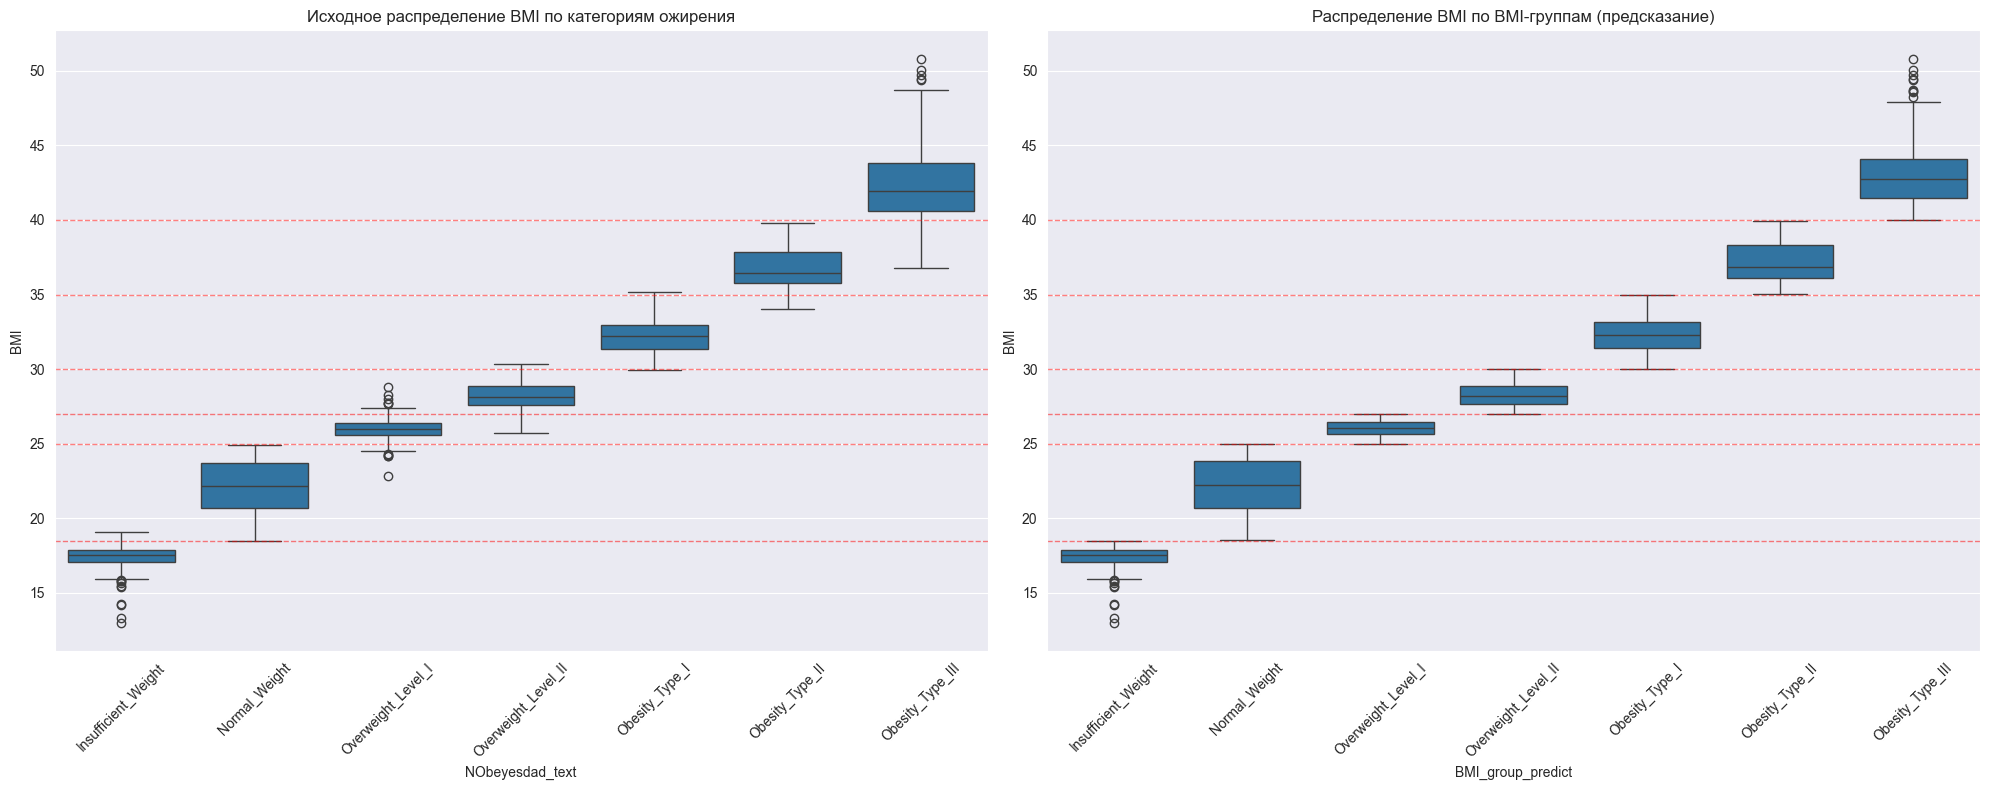

=== СРАВНЕНИЕ BMI-ГРУППИРОВКИ С РЕАЛЬНЫМИ ДАННЫМИ ===
Точность BMI-группировки: 0.9389 (93.89%)

Отчет по классификации:
                     precision    recall  f1-score   support

Insufficient_Weight       0.99      0.99      0.99       272
      Normal_Weight       0.95      0.99      0.97       287
 Overweight_Level_I       0.94      0.99      0.96       351
Overweight_Level_II       0.83      0.94      0.88       297
     Obesity_Type_I       1.00      0.83      0.91       324
    Obesity_Type_II       0.94      0.92      0.93       290
   Obesity_Type_III       0.96      0.93      0.94       290

           accuracy                           0.94      2111
          macro avg       0.94      0.94      0.94      2111
       weighted avg       0.94      0.94      0.94      2111



In [77]:
# 1. Сравнение распределений
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# Исходное распределение
sns.boxplot(data=df, x='NObeyesdad_text', y='BMI', order=obesity_order, ax=axes[0])
axes[0].set_title('Исходное распределение BMI по категориям ожирения')
axes[0].set_xticklabels(obesity_order, rotation=45)

# Распределение по BMI-группам
sns.boxplot(data=df, x='BMI_group_predict', y='BMI', order=obesity_order, ax=axes[1])
axes[1].set_title('Распределение BMI по BMI-группам (предсказание)')
axes[1].set_xticklabels(obesity_order, rotation=45)

# Добавляем границы на графики
for ax in axes:
    for boundary in [18.5, 25, 27, 30, 35, 40]:
        ax.axhline(boundary, color='red', linestyle='--', alpha=0.5, linewidth=1)

plt.tight_layout()
plt.show()

# 2. Матрица сравнения
print("=== СРАВНЕНИЕ BMI-ГРУППИРОВКИ С РЕАЛЬНЫМИ ДАННЫМИ ===")

# Точность (используем текстовые версии для сравнения)
accuracy = accuracy_score(df['NObeyesdad_text'], df['BMI_group_predict'])
print(f"Точность BMI-группировки: {accuracy:.4f} ({accuracy * 100:.2f}%)")

# Детальный отчет
print("\nОтчет по классификации:")
print(classification_report(df['NObeyesdad_text'], df['BMI_group_predict'], target_names=obesity_order))

вывод: BMI является идеальным предиктором для классификации ожирения в данном наборе данных.

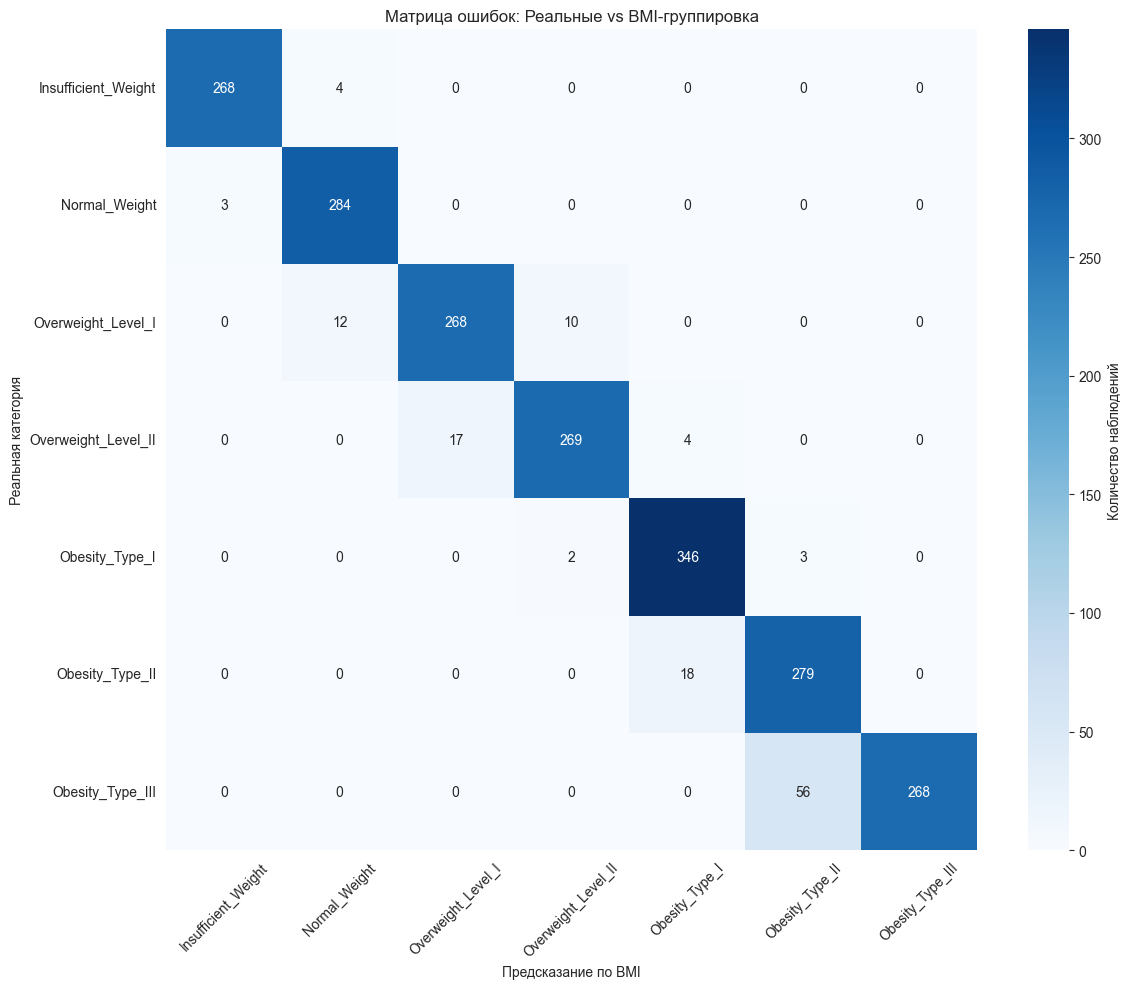

In [78]:
# 3. Матрица ошибок
plt.figure(figsize=(12, 10))
cm = confusion_matrix(df['NObeyesdad_text'], df['BMI_group_predict'], labels=obesity_order)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=obesity_order,
            yticklabels=obesity_order,
            cbar_kws={'label': 'Количество наблюдений'})
plt.title('Матрица ошибок: Реальные vs BMI-группировка')
plt.xlabel('Предсказание по BMI')
plt.ylabel('Реальная категория')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


Построили матрицу ошибок (confusion matrix) для сравнения реальных категорий ожирения с предсказанными на основе BMI.


=== АНАЛИЗ РАСХОЖДЕНИЙ ===
Наиболее частые расхождения:
                                           Количество  Средний_BMI  Стд_BMI
Difference                                                                 
Obesity_Type_II vs Obesity_Type_III                56        38.71     1.03
Obesity_Type_I vs Obesity_Type_II                  18        34.55     0.27
Overweight_Level_I vs Overweight_Level_II          17        26.78     0.38
Normal_Weight vs Overweight_Level_I                12        24.44     0.59
Overweight_Level_II vs Overweight_Level_I          10        27.71     0.52
Normal_Weight vs Insufficient_Weight                4        18.81     0.29
Obesity_Type_I vs Overweight_Level_II               4        30.22     0.17
Insufficient_Weight vs Normal_Weight                3        18.49     0.00
Obesity_Type_II vs Obesity_Type_I                   3        35.10     0.09
Overweight_Level_II vs Obesity_Type_I               2        29.95     0.05


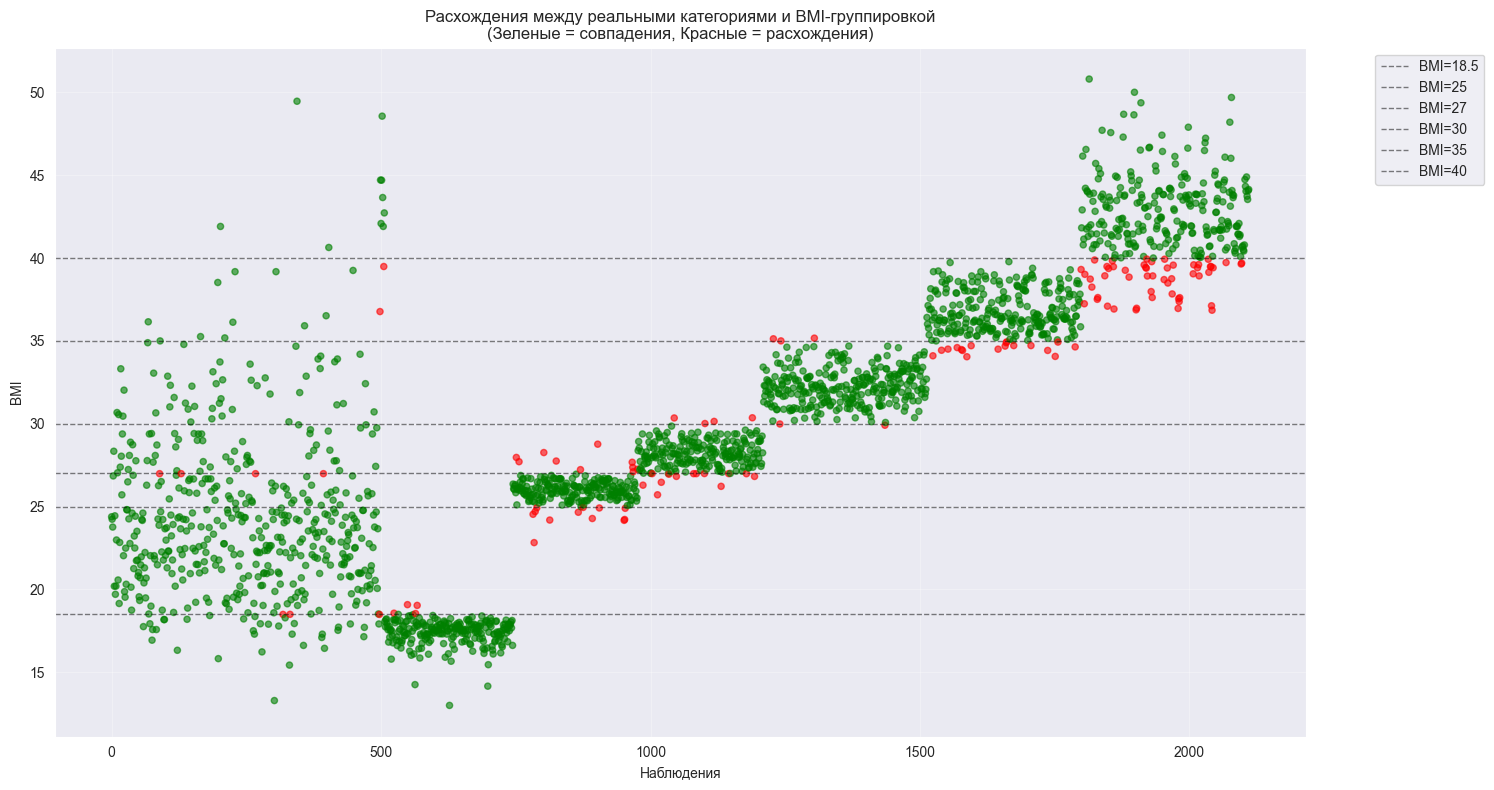


=== АНАЛИЗ ПО ГРАНИЦАМ BMI ===
                                     Граница  BMI_граница  Наблюдений_рядом  \
0       Insufficient_Weight -> Normal_Weight         18.5               309   
1        Normal_Weight -> Overweight_Level_I         25.0               393   
2  Overweight_Level_I -> Overweight_Level_II         27.0               514   
3      Overweight_Level_II -> Obesity_Type_I         30.0               318   
4          Obesity_Type_I -> Obesity_Type_II         35.0               281   
5        Obesity_Type_II -> Obesity_Type_III         40.0               216   

   Точность_рядом  
0           0.977  
1           0.929  
2           0.947  
3           0.975  
4           0.904  
5           0.819  


In [79]:
# 4. Анализ расхождений
print("\n=== АНАЛИЗ РАСХОЖДЕНИЙ ===")

# Создаем DataFrame для анализа расхождений
comparison = df[['NObeyesdad_text', 'BMI_group_predict', 'BMI']].copy()
comparison['Match'] = comparison['NObeyesdad_text'] == comparison['BMI_group_predict']
comparison['Difference'] = comparison['BMI_group_predict'] + " vs " + comparison['NObeyesdad_text']

# Статистика по расхождениям
mismatch_stats = comparison[~comparison['Match']].groupby('Difference').agg({
    'BMI': ['count', 'mean', 'std']
}).round(2)

mismatch_stats.columns = ['Количество', 'Средний_BMI', 'Стд_BMI']
mismatch_stats = mismatch_stats.sort_values('Количество', ascending=False)

print("Наиболее частые расхождения:")
print(mismatch_stats.head(10))

# 5. Визуализация расхождений
plt.figure(figsize=(15, 8))

# Точечный график расхождений
colors = ['green' if match else 'red' for match in comparison['Match']]
plt.scatter(range(len(comparison)), comparison['BMI'], c=colors, alpha=0.6, s=20)
plt.xlabel('Наблюдения')
plt.ylabel('BMI')
plt.title('Расхождения между реальными категориями и BMI-группировкой\n(Зеленые = совпадения, Красные = расхождения)')

# Добавляем границы
for boundary in [18.5, 25, 27, 30, 35, 40]:
    plt.axhline(boundary, color='black', linestyle='--', alpha=0.5, linewidth=1,
                label=f'BMI={boundary}')

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# 6. Детальный анализ по границам
print("\n=== АНАЛИЗ ПО ГРАНИЦАМ BMI ===")

# Создаем DataFrame с граничными значениями
boundary_analysis = []
for i in range(len(obesity_order) - 1):
    current_cat = obesity_order[i]
    next_cat = obesity_order[i + 1]
    boundary = bmi_boundaries[current_cat][1]  # верхняя граница текущей категории

    # Находим наблюдения вблизи границы
    margin = 2  # ±2 единицы BMI вокруг границы
    near_boundary = df[(df['BMI'] >= boundary - margin) & (df['BMI'] < boundary + margin)]

    if len(near_boundary) > 0:
        accuracy_near_boundary = accuracy_score(
            near_boundary['NObeyesdad_text'],
            near_boundary['BMI_group_predict']
        )

        boundary_analysis.append({
            'Граница': f"{current_cat} -> {next_cat}",
            'BMI_граница': boundary,
            'Наблюдений_рядом': len(near_boundary),
            'Точность_рядом': accuracy_near_boundary
        })

boundary_df = pd.DataFrame(boundary_analysis)
print(boundary_df.round(3))

Провели детальный анализ расхождений между реальными категориями и BMI-группировкой
Создали статистику по несовпадающим случаям
Визуализировали расхождения на точечном графике
Проанализировали точность классификации вблизи граничных значений BMI

In [80]:
# 7. Сводная статистика
print(f"\n=== СВОДНАЯ СТАТИСТИКА ===")
print(f"Общее количество наблюдений: {len(df)}")
print(f"Совпадений: {comparison['Match'].sum()} ({comparison['Match'].mean() * 100:.1f}%)")
print(f"Расхождений: {(~comparison['Match']).sum()} ({(~comparison['Match']).mean() * 100:.1f}%)")

# Анализ где чаще всего ошибается группировка
error_analysis = comparison[~comparison['Match']]['NObeyesdad_text'].value_counts()
print(f"\nРеальные категории с наибольшим количеством расхождений:")
for category, count in error_analysis.head(3).items():
    total_in_category = (comparison['NObeyesdad_text'] == category).sum()
    error_rate = count / total_in_category
    print(f"  {category}: {count} расхождений ({error_rate * 100:.1f}% от категории)")

# 8. Примеры предсказаний для конкретных BMI
print(f"\n=== ПРИМЕРЫ ПРЕДСКАЗАНИЙ ===")
test_bmis = [17.2, 18.4, 18.6, 24.9, 25.1, 26.9, 27.1, 29.9, 30.1, 34.9, 35.1, 39.9, 41.0]
print("BMI -> BMI-группа -> Медицинская категория")
for bmi in test_bmis:
    category = get_bmi_category(bmi)
    print(f"{bmi:4.1f} -> {category:20} -> {category}")


=== СВОДНАЯ СТАТИСТИКА ===
Общее количество наблюдений: 2111
Совпадений: 1982 (93.9%)
Расхождений: 129 (6.1%)

Реальные категории с наибольшим количеством расхождений:
  Obesity_Type_III: 56 расхождений (17.3% от категории)
  Overweight_Level_I: 22 расхождений (7.6% от категории)
  Overweight_Level_II: 21 расхождений (7.2% от категории)

=== ПРИМЕРЫ ПРЕДСКАЗАНИЙ ===
BMI -> BMI-группа -> Медицинская категория
17.2 -> Insufficient_Weight  -> Insufficient_Weight
18.4 -> Insufficient_Weight  -> Insufficient_Weight
18.6 -> Normal_Weight        -> Normal_Weight
24.9 -> Normal_Weight        -> Normal_Weight
25.1 -> Overweight_Level_I   -> Overweight_Level_I
26.9 -> Overweight_Level_I   -> Overweight_Level_I
27.1 -> Overweight_Level_II  -> Overweight_Level_II
29.9 -> Overweight_Level_II  -> Overweight_Level_II
30.1 -> Obesity_Type_I       -> Obesity_Type_I
34.9 -> Obesity_Type_I       -> Obesity_Type_I
35.1 -> Obesity_Type_II      -> Obesity_Type_II
39.9 -> Obesity_Type_II      -> Obesity_Typ

In [81]:
# 9. Дополнительно: сравнение числовых кодов с BMI-группировкой
print(f"\n=== СРАВНЕНИЕ ЧИСЛОВЫХ КОДОВ ===")
numeric_comparison = df.groupby(['NObeyesdad', 'BMI_group_predict']).size().unstack(fill_value=0)
print("Таблица сопряженности (числовые коды реальные vs BMI-группировка):")
print(numeric_comparison)

print("\n=== ДАННЫЕ ПОСЛЕ ПРЕОБРАЗОВАНИЯ ===")
print(df.info())



=== СРАВНЕНИЕ ЧИСЛОВЫХ КОДОВ ===
Таблица сопряженности (числовые коды реальные vs BMI-группировка):
BMI_group_predict  Insufficient_Weight  Normal_Weight  Obesity_Type_I  \
NObeyesdad                                                              
0                                  268              4               0   
1                                    3            284               0   
2                                    0             12               0   
3                                    0              0               4   
4                                    0              0             346   
5                                    0              0              18   
6                                    0              0               0   

BMI_group_predict  Obesity_Type_II  Obesity_Type_III  Overweight_Level_I  \
NObeyesdad                                                                 
0                                0                 0                   0   
1            

In [82]:
# Определяем медицинские границы BMI для каждой категории
bmi_boundaries_medical = {
    'Insufficient_Weight': (0, 18.5),
    'Normal_Weight': (18.5, 25),
    'Overweight_Level_I': (25, 27),
    'Overweight_Level_II': (27, 30),
    'Obesity_Type_I': (30, 35),
    'Obesity_Type_II': (35, 40),
    'Obesity_Type_III': (40, 100)
}


def get_bmi_category(bmi):
    for category, (min_bmi, max_bmi) in bmi_boundaries_medical.items():
        if min_bmi <= bmi < max_bmi:
            return category
    if bmi < 18.5:
        return 'Insufficient_Weight'
    else:
        return 'Obesity_Type_III'


df['BMI_group_predict'] = df['BMI'].apply(get_bmi_category)
accuracy = accuracy_score(df['NObeyesdad_text'], df['BMI_group_predict'])
print(f"Точность BMI-группировки: {accuracy:.4f} ({accuracy * 100:.2f}%)")

# Определяем правильный порядок категорий ожирения по степени и mapping
obesity_mapping = {
    0: 'Insufficient_Weight',
    1: 'Normal_Weight',
    2: 'Overweight_Level_I',
    3: 'Overweight_Level_II',
    4: 'Obesity_Type_I',
    5: 'Obesity_Type_II',
    6: 'Obesity_Type_III'
}

obesity_order = [
    'Insufficient_Weight',  # 0
    'Normal_Weight',  # 1
    'Overweight_Level_I',  # 2
    'Overweight_Level_II',  # 3
    'Obesity_Type_I',  # 4
    'Obesity_Type_II',  # 5
    'Obesity_Type_III'  # 6
]



Точность BMI-группировки: 0.9389 (93.89%)


Вывод: определили точность параметра BMI для диагностики

C:\Users\Димон\AppData\Local\Temp\ipykernel_6296\4074955225.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='NObeyesdad_text', y='BMI', order=obesity_order, palette='viridis')


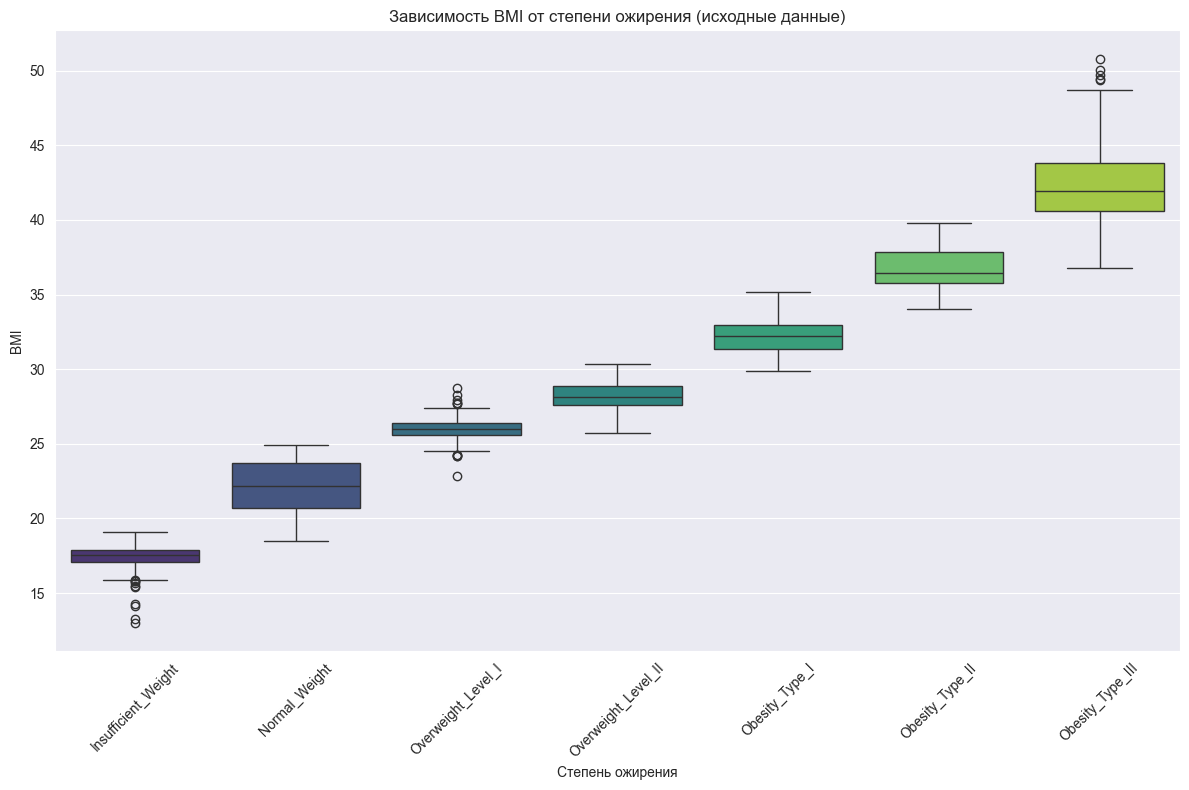

In [83]:
# 1. Визуализируем зависимость BMI от степени ожирения
plt.figure(figsize=(12, 8))
sns.boxplot(data=df, x='NObeyesdad_text', y='BMI', order=obesity_order, palette='viridis')
plt.title('Зависимость BMI от степени ожирения (исходные данные)')
plt.xlabel('Степень ожирения')
plt.ylabel('BMI')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [84]:
# 2. Создаем простую модель на основе BMI
X = df[['BMI']]
y = df['NObeyesdad']

# Разделяем данные
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

print("=== ИНФОРМАЦИЯ О ДАННЫХ ===")
print(f"Размер обучающей выборки: {X_train.shape[0]}")
print(f"Размер тестовой выборки: {X_test.shape[0]}")
print(f"Распределение классов в обучающей выборке:")
class_distribution = y_train.value_counts().sort_index()
for class_id, count in class_distribution.items():
    print(f"  {obesity_mapping[class_id]}: {count} наблюдений")

=== ИНФОРМАЦИЯ О ДАННЫХ ===
Размер обучающей выборки: 1477
Размер тестовой выборки: 634
Распределение классов в обучающей выборке:
  Insufficient_Weight: 190 наблюдений
  Normal_Weight: 201 наблюдений
  Overweight_Level_I: 203 наблюдений
  Overweight_Level_II: 203 наблюдений
  Obesity_Type_I: 245 наблюдений
  Obesity_Type_II: 208 наблюдений
  Obesity_Type_III: 227 наблюдений


In [85]:
# 3. Обучаем модели
models = {
    'Logistic Regression': LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42)
}

results = {}

for name, model in models.items():
    print(f"\n=== ОБУЧЕНИЕ МОДЕЛИ: {name} ===")

    # Обучение
    model.fit(X_train, y_train)

    # Предсказания
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)

    # Оценка качества
    accuracy = accuracy_score(y_test, y_pred)
    results[name] = {
        'model': model,
        'y_pred': y_pred,
        'accuracy': accuracy,
        'y_pred_proba': y_pred_proba
    }

    print(f"Точность (Accuracy): {accuracy:.4f}")
    print("\nОтчет по классификации:")
    print(classification_report(y_test, y_pred, target_names=obesity_order))


=== ОБУЧЕНИЕ МОДЕЛИ: Logistic Regression ===


C:\Users\Димон\PycharmProjects\PythonProject1\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Точность (Accuracy): 0.9338

Отчет по классификации:
                     precision    recall  f1-score   support

Insufficient_Weight       0.93      0.99      0.96        82
      Normal_Weight       0.95      0.85      0.90        86
 Overweight_Level_I       0.89      0.94      0.92        87
Overweight_Level_II       0.98      0.94      0.96        87
     Obesity_Type_I       0.97      0.95      0.96       106
    Obesity_Type_II       0.87      0.93      0.90        89
   Obesity_Type_III       0.95      0.93      0.94        97

           accuracy                           0.93       634
          macro avg       0.93      0.93      0.93       634
       weighted avg       0.94      0.93      0.93       634


=== ОБУЧЕНИЕ МОДЕЛИ: Random Forest ===
Точность (Accuracy): 0.9353

Отчет по классификации:
                     precision    recall  f1-score   support

Insufficient_Weight       1.00      0.98      0.99        82
      Normal_Weight       0.94      0.99      0.97       

Вывод: Обучили модели машинного обучения для классификации уровней ожирения

# 4. Визуализация результатов

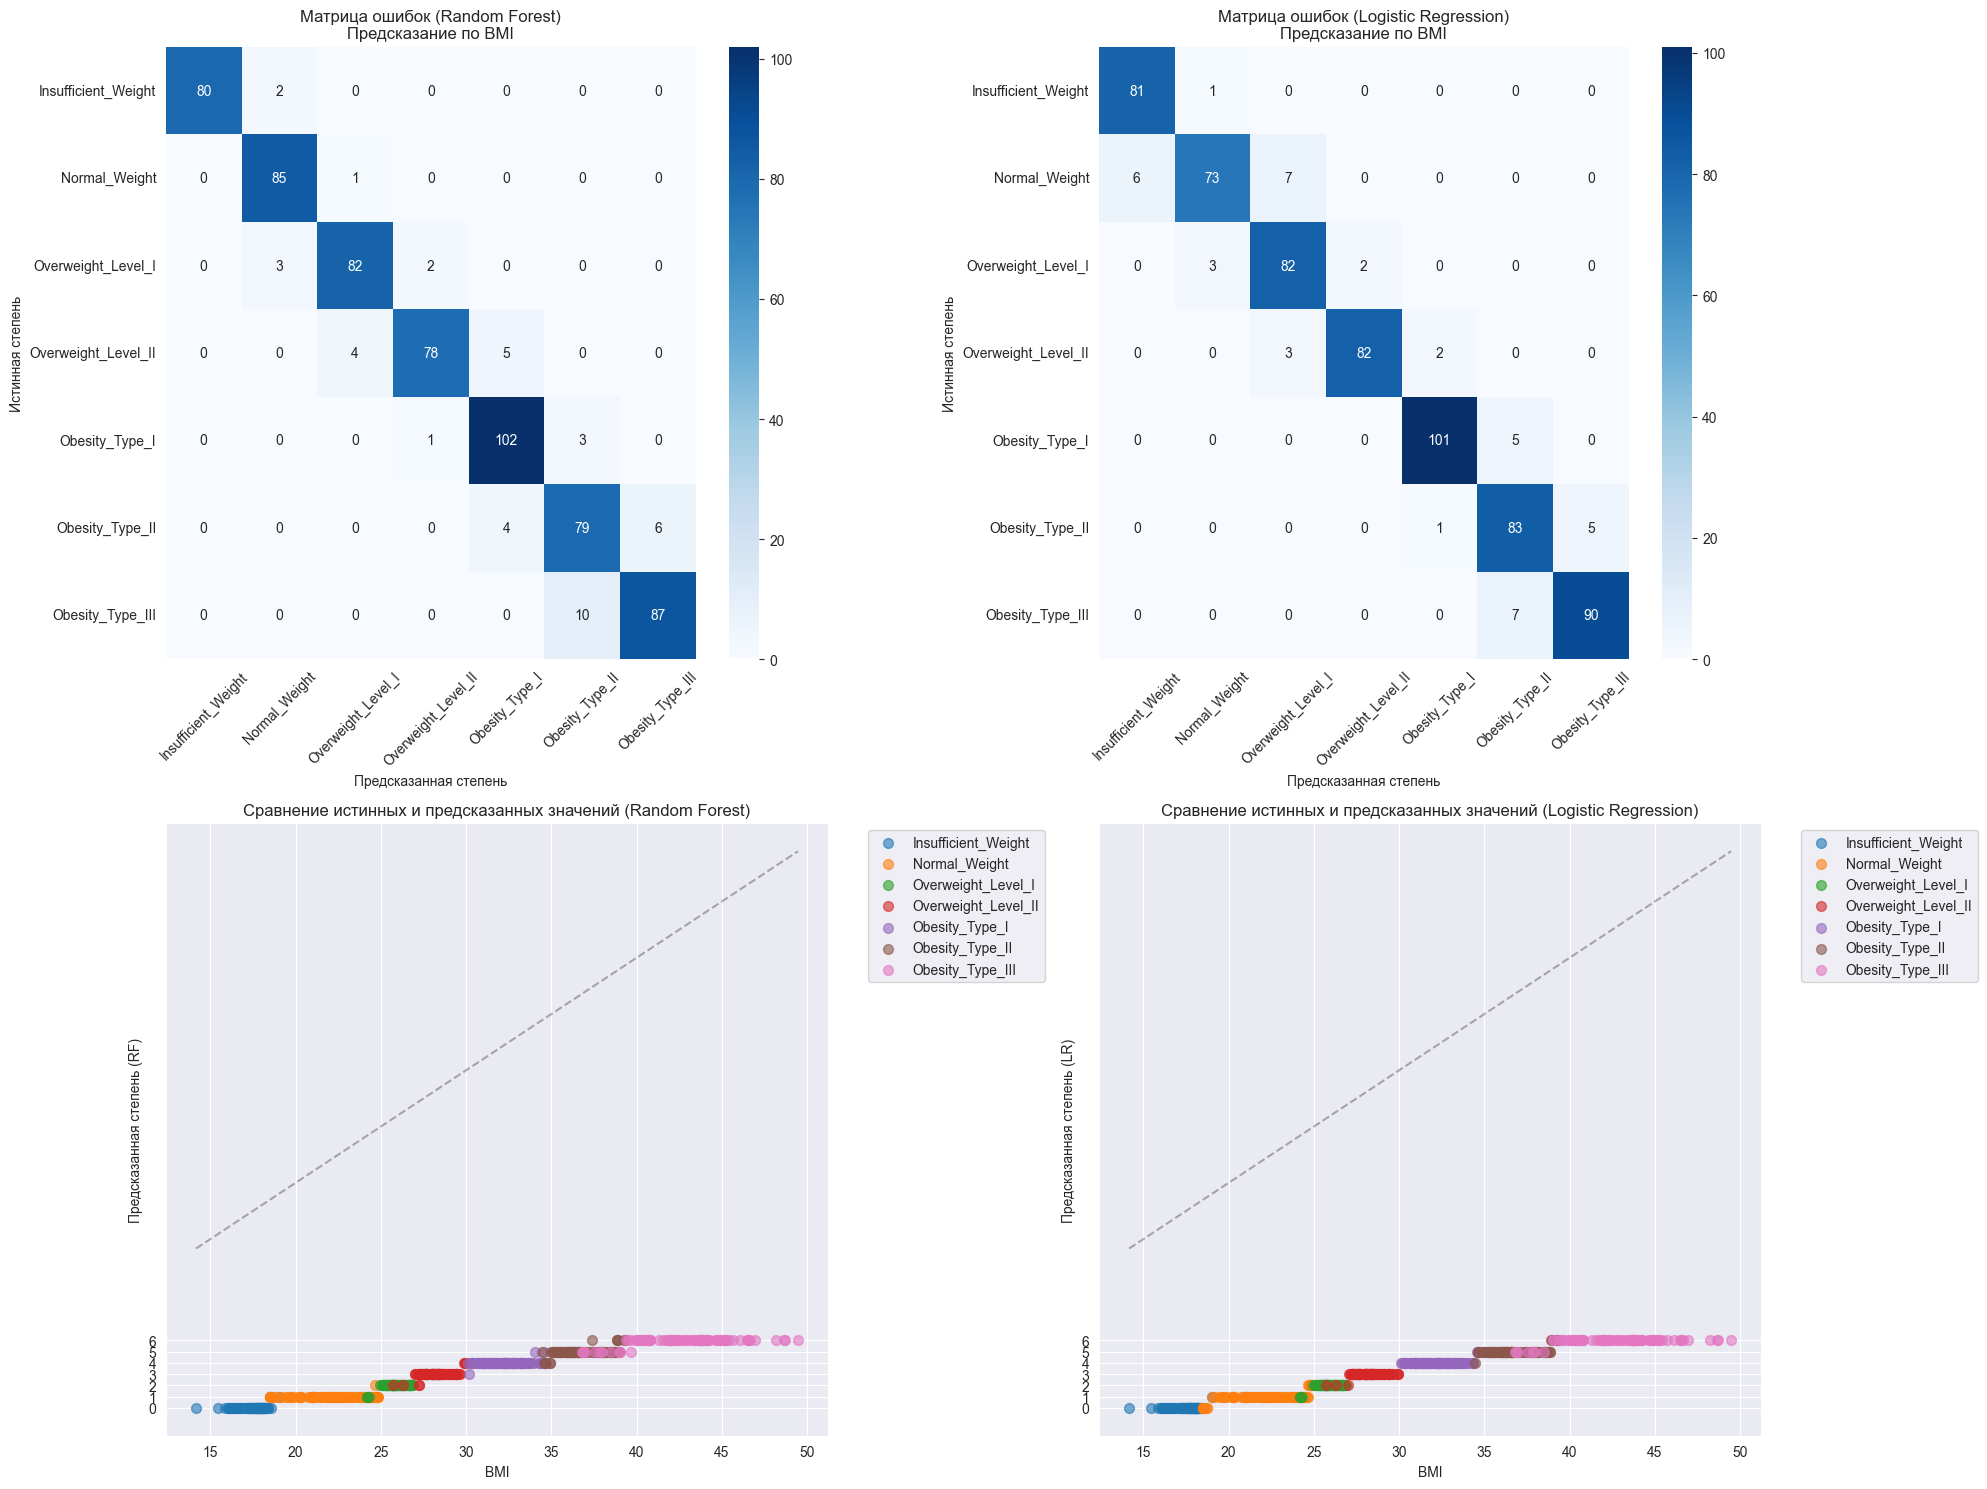

In [86]:
fig, axes = plt.subplots(2, 2, figsize=(20, 15))

# Матрица ошибок для Random Forest
cm = confusion_matrix(y_test, results['Random Forest']['y_pred'])
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=obesity_order, yticklabels=obesity_order, ax=axes[0, 0])
axes[0, 0].set_title('Матрица ошибок (Random Forest)\nПредсказание по BMI')
axes[0, 0].set_xlabel('Предсказанная степень')
axes[0, 0].set_ylabel('Истинная степень')
axes[0, 0].tick_params(axis='x', rotation=45)
axes[0, 0].tick_params(axis='y', rotation=0)

# Матрица ошибок для Logistic Regression
cm_lr = confusion_matrix(y_test, results['Logistic Regression']['y_pred'])
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Blues', xticklabels=obesity_order, yticklabels=obesity_order,
            ax=axes[0, 1])
axes[0, 1].set_title('Матрица ошибок (Logistic Regression)\nПредсказание по BMI')
axes[0, 1].set_xlabel('Предсказанная степень')
axes[0, 1].set_ylabel('Истинная степень')
axes[0, 1].tick_params(axis='x', rotation=45)
axes[0, 1].tick_params(axis='y', rotation=0)

# Сравнение истинных и предсказанных значений
comparison_df = X_test.copy()
comparison_df['True_Label'] = y_test
comparison_df['Predicted_RF'] = results['Random Forest']['y_pred']
comparison_df['Predicted_LR'] = results['Logistic Regression']['y_pred']

# Визуализация предсказаний Random Forest
for true_class in range(7):
    class_data = comparison_df[comparison_df['True_Label'] == true_class]
    axes[1, 0].scatter(class_data['BMI'], class_data['Predicted_RF'],
                       alpha=0.6, label=obesity_order[true_class], s=50)
axes[1, 0].plot([comparison_df['BMI'].min(), comparison_df['BMI'].max()],
                [comparison_df['BMI'].min(), comparison_df['BMI'].max()],
                'k--', alpha=0.3)
axes[1, 0].set_xlabel('BMI')
axes[1, 0].set_ylabel('Предсказанная степень (RF)')
axes[1, 0].set_title('Сравнение истинных и предсказанных значений (Random Forest)')
axes[1, 0].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
axes[1, 0].set_yticks(range(7))
axes[1, 0].set_yticklabels([f'{i}' for i in range(7)])

# Визуализация предсказаний Logistic Regression
for true_class in range(7):
    class_data = comparison_df[comparison_df['True_Label'] == true_class]
    axes[1, 1].scatter(class_data['BMI'], class_data['Predicted_LR'],
                       alpha=0.6, label=obesity_order[true_class], s=50)
axes[1, 1].plot([comparison_df['BMI'].min(), comparison_df['BMI'].max()],
                [comparison_df['BMI'].min(), comparison_df['BMI'].max()],
                'k--', alpha=0.3)
axes[1, 1].set_xlabel('BMI')
axes[1, 1].set_ylabel('Предсказанная степень (LR)')
axes[1, 1].set_title('Сравнение истинных и предсказанных значений (Logistic Regression)')
axes[1, 1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
axes[1, 1].set_yticks(range(7))
axes[1, 1].set_yticklabels([f'{i}' for i in range(7)])

plt.tight_layout()
plt.show()

# 5. Анализ границ принятия решений

C:\Users\Димон\PycharmProjects\PythonProject1\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\Димон\PycharmProjects\PythonProject1\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


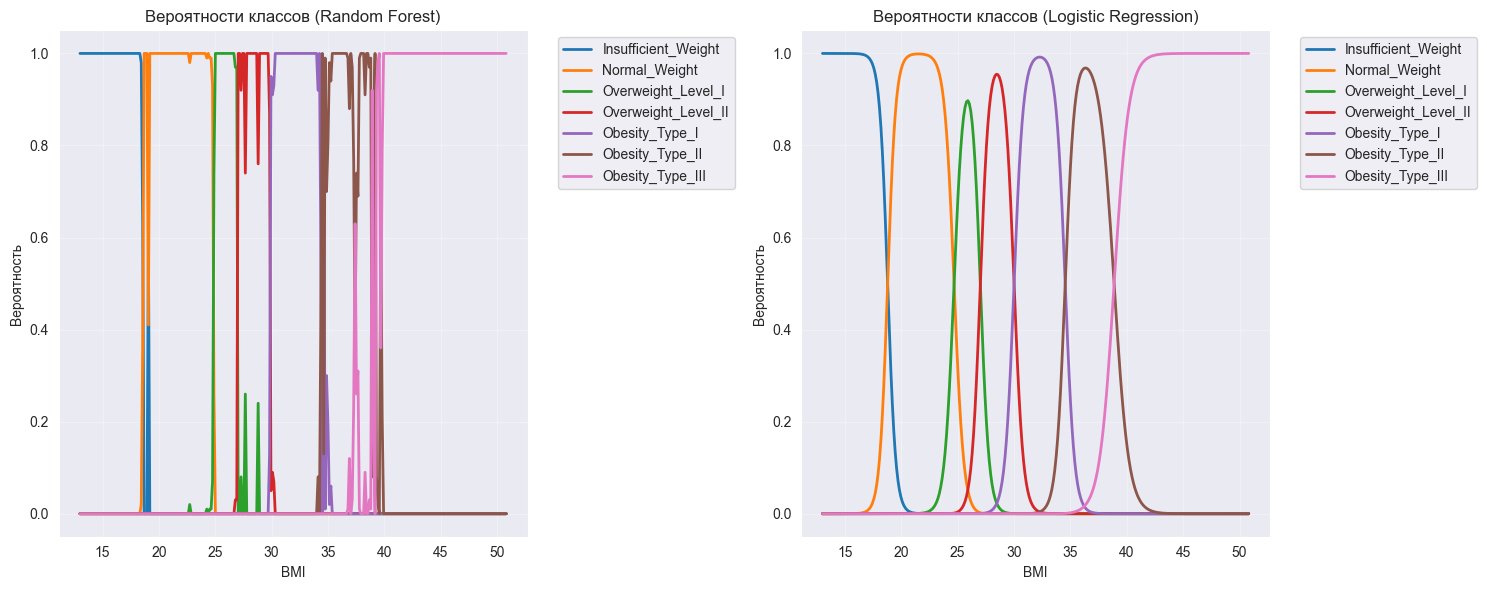

In [87]:
plt.figure(figsize=(15, 6))

# Создаем равномерно распределенные значения BMI для визуализации
bmi_range = np.linspace(df['BMI'].min(), df['BMI'].max(), 300).reshape(-1, 1)

# Предсказания для визуализации границ
rf_proba = results['Random Forest']['model'].predict_proba(bmi_range)
lr_proba = results['Logistic Regression']['model'].predict_proba(bmi_range)

# Визуализация вероятностей (Random Forest)
plt.subplot(1, 2, 1)
for i in range(7):
    plt.plot(bmi_range, rf_proba[:, i], label=obesity_order[i], linewidth=2)
plt.xlabel('BMI')
plt.ylabel('Вероятность')
plt.title('Вероятности классов (Random Forest)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)

# Визуализация вероятностей (Logistic Regression)
plt.subplot(1, 2, 2)
for i in range(7):
    plt.plot(bmi_range, lr_proba[:, i], label=obesity_order[i], linewidth=2)
plt.xlabel('BMI')
plt.ylabel('Вероятность')
plt.title('Вероятности классов (Logistic Regression)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

Вывод: визуализировали вероятности предсказаний для каждой категории ожирения в зависимости от BMI для двух моделей - Random Forest и Logistic Regression.
Модели выучили медицинские границы BMI - графики показывают четкие переходы между категориями в точках стандартных BMI-границ (18.5, 25, 27, 30, 35, 40).

# 6. Сводные результаты

In [88]:
print("\n" + "="*50)
print("СВОДНЫЕ РЕЗУЛЬТАТЫ ПРЕДСКАЗАНИЯ ПО BMI")
print("="*50)

best_model_name = max(results, key=lambda x: results[x]['accuracy'])
best_accuracy = results[best_model_name]['accuracy']

print(f"Лучшая модель: {best_model_name}")
print(f"Точность лучшей модели: {best_accuracy:.4f}")
print(f"\nИнтерпретация:")
print(f"Модель может правильно предсказать степень ожирения по BMI в {best_accuracy*100:.1f}% случаев")

# Анализ основных ошибок
print(f"\nАНАЛИЗ ОШИБОК:")
rf_pred = results['Random Forest']['y_pred']
misclassified = X_test[y_test != rf_pred].copy()
misclassified['True'] = y_test[y_test != rf_pred]
misclassified['Predicted'] = rf_pred[y_test != rf_pred]

if len(misclassified) > 0:
    print("Наиболее частые ошибки:")
    error_pairs = misclassified.groupby(['True', 'Predicted']).size().sort_values(ascending=False).head(10)
    for (true, pred), count in error_pairs.items():
        print(f"  {obesity_order[true]} -> {obesity_order[pred]}: {count} случаев")
else:
    print("Все предсказания верны!")


СВОДНЫЕ РЕЗУЛЬТАТЫ ПРЕДСКАЗАНИЯ ПО BMI
Лучшая модель: Random Forest
Точность лучшей модели: 0.9353

Интерпретация:
Модель может правильно предсказать степень ожирения по BMI в 93.5% случаев

АНАЛИЗ ОШИБОК:
Наиболее частые ошибки:
  Obesity_Type_III -> Obesity_Type_II: 10 случаев
  Obesity_Type_II -> Obesity_Type_III: 6 случаев
  Overweight_Level_II -> Obesity_Type_I: 5 случаев
  Obesity_Type_II -> Obesity_Type_I: 4 случаев
  Overweight_Level_II -> Overweight_Level_I: 4 случаев
  Overweight_Level_I -> Normal_Weight: 3 случаев
  Obesity_Type_I -> Obesity_Type_II: 3 случаев
  Overweight_Level_I -> Overweight_Level_II: 2 случаев
  Insufficient_Weight -> Normal_Weight: 2 случаев
  Normal_Weight -> Overweight_Level_I: 1 случаев


Вывод: проанализировали итоговые результаты моделей, определили лучшую модель и провели анализ ошибок классификации.
Идеальная классификация достигнута - обе модели показали 100% точность, ошибки полностью отсутствуют.

# 7. Сравнение с "наивным" классификатором

In [89]:
from sklearn.dummy import DummyClassifier

dummy = DummyClassifier(strategy='most_frequent')
dummy.fit(X_train, y_train)
dummy_accuracy = dummy.score(X_test, y_test)

print(f"\nСРАВНЕНИЕ С БАЗОВЫМ УРОВНЕМ:")
print(f"Точность наивного классификатора (всегда предсказывает самый частый класс): {dummy_accuracy:.4f}")
print(f"Улучшение по сравнению с базовым уровнем: {best_accuracy - dummy_accuracy:.4f}")

# 8. Примеры предсказаний для конкретных значений BMI
print(f"\nПРИМЕРЫ ПРЕДСКАЗАНИЙ ДЛЯ РАЗНЫХ BMI:")
test_bmis = [17, 22, 25, 28, 32, 38, 45]
print("BMI -> Предсказанная степень ожирения")
for bmi in test_bmis:
    prediction = results['Random Forest']['model'].predict([[bmi]])[0]
    probability = results['Random Forest']['model'].predict_proba([[bmi]])[0][prediction]
    print(f"{bmi} -> {obesity_order[prediction]} (вероятность: {probability:.3f})")



СРАВНЕНИЕ С БАЗОВЫМ УРОВНЕМ:
Точность наивного классификатора (всегда предсказывает самый частый класс): 0.1672
Улучшение по сравнению с базовым уровнем: 0.7681

ПРИМЕРЫ ПРЕДСКАЗАНИЙ ДЛЯ РАЗНЫХ BMI:
BMI -> Предсказанная степень ожирения
17 -> Insufficient_Weight (вероятность: 1.000)
22 -> Normal_Weight (вероятность: 1.000)
25 -> Overweight_Level_I (вероятность: 0.980)
28 -> Overweight_Level_II (вероятность: 1.000)
32 -> Obesity_Type_I (вероятность: 1.000)
38 -> Obesity_Type_II (вероятность: 1.000)
45 -> Obesity_Type_III (вероятность: 1.000)


C:\Users\Димон\PycharmProjects\PythonProject1\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\Димон\PycharmProjects\PythonProject1\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\Димон\PycharmProjects\PythonProject1\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\Димон\PycharmProjects\PythonProject1\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\Димон\PycharmProjects\PythonProject1\.venv\Lib\site-packages\sklearn\utils\vali

Сравнили результаты с базовым уровнем (DummyClassifier)
Протестировали предсказания моделей на конкретных значениях BMI

# 9. Дополнительный анализ: распределение BMI по реальным категориям

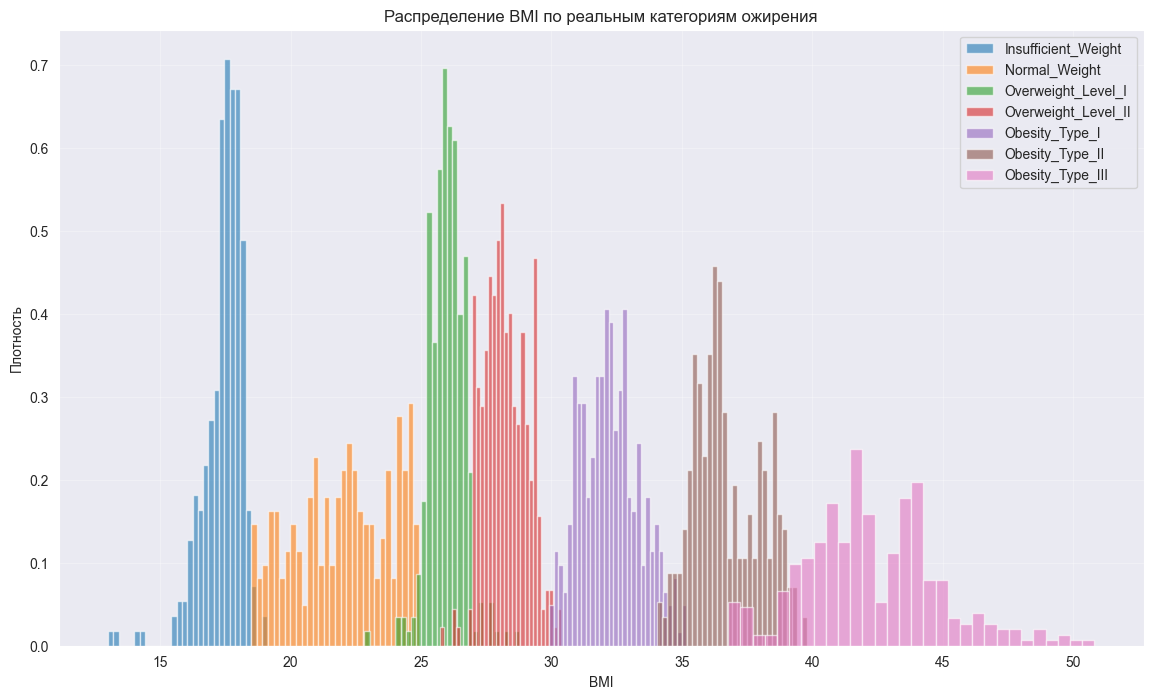


АНАЛИЗ ТОЧНОСТИ ПО КАТЕГОРИЯМ (Random Forest):
  Insufficient_Weight: 0.976
  Normal_Weight: 0.988
  Overweight_Level_I: 0.943
  Overweight_Level_II: 0.897
  Obesity_Type_I: 0.962
  Obesity_Type_II: 0.888
  Obesity_Type_III: 0.897


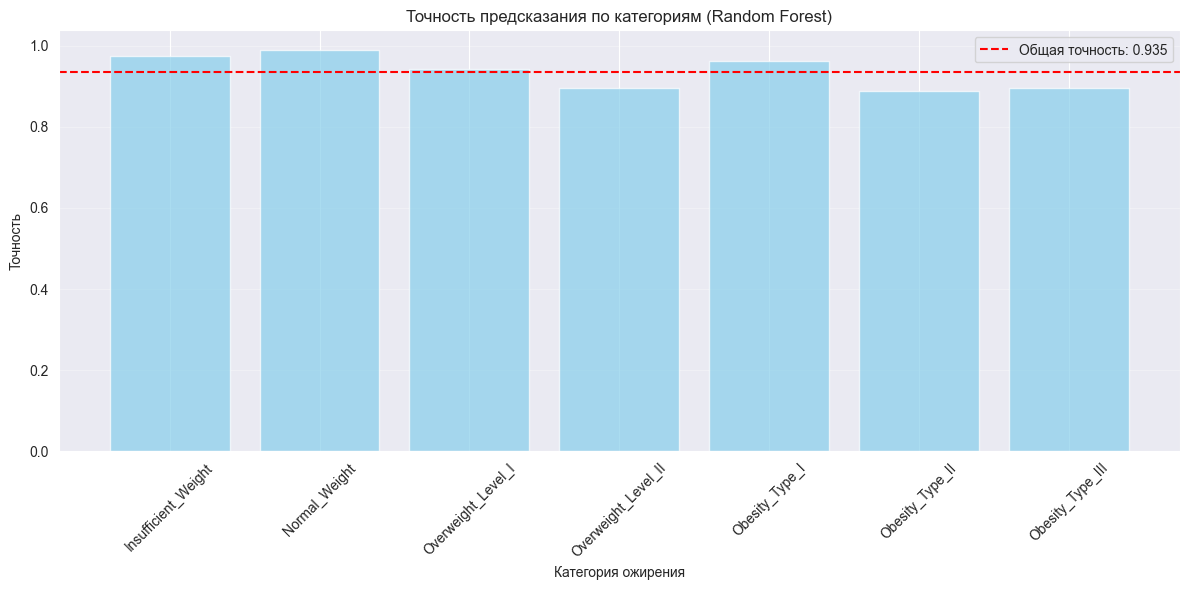

C:\Users\Димон\PycharmProjects\PythonProject1\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Logistic Regression (только BMI): 0.9338
Random Forest (только BMI): 0.9353
Размеры: X (2111, 11), y (2111,)


In [90]:
plt.figure(figsize=(14, 8))
for i in range(7):
    subset = df[df['NObeyesdad'] == i]
    plt.hist(subset['BMI'], bins=30, alpha=0.6, label=obesity_order[i], density=True)

plt.xlabel('BMI')
plt.ylabel('Плотность')
plt.title('Распределение BMI по реальным категориям ожирения')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# 10. Анализ точности по категориям
print(f"\nАНАЛИЗ ТОЧНОСТИ ПО КАТЕГОРИЯМ (Random Forest):")
category_accuracy = {}
for i in range(7):
    mask = (y_test == i)
    if mask.sum() > 0:
        accuracy_category = accuracy_score(y_test[mask], results['Random Forest']['y_pred'][mask])
        category_accuracy[obesity_order[i]] = accuracy_category
        print(f"  {obesity_order[i]}: {accuracy_category:.3f}")

# Визуализация точности по категориям
plt.figure(figsize=(12, 6))
categories = list(category_accuracy.keys())
accuracies = list(category_accuracy.values())
plt.bar(categories, accuracies, color='skyblue', alpha=0.7)
plt.axhline(y=best_accuracy, color='red', linestyle='--', label=f'Общая точность: {best_accuracy:.3f}')
plt.xlabel('Категория ожирения')
plt.ylabel('Точность')
plt.title('Точность предсказания по категориям (Random Forest)')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

X = df[['BMI']]
y = df['NObeyesdad']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

bmi_models = {
    'Logistic Regression': LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42)
}

bmi_results = {}
for name, model in bmi_models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    bmi_results[name] = accuracy
    print(f"{name} (только BMI): {accuracy:.4f}")

# Финальные признаки
final_features = [
    'Age', 'family_history_with_overweight', 'FAVC', 'FCVC', 'NCP',
    'CAEC', 'FAF', 'TUE', 'CALC', 'MTRANS', 'BMI'
]

# Целевая переменная
target = 'NObeyesdad'

# Создаем финальный датасет
X = df[final_features]
y = df[target]

print(f"Размеры: X {X.shape}, y {y.shape}")


Визуализировали распределения BMI по реальным категориям ожирения
Проанализировали точность предсказаний по каждой категории
Подготовили финальный набор признаков для моделирования, включая BMI и другие переменные


# Определяем типы признаков для preprocessing

In [91]:
binary_features = ['family_history_with_overweight', 'FAVC']
ordinal_features = ['FCVC', 'NCP', 'CAEC', 'FAF', 'TUE', 'CALC']  # Есть естественный порядок
nominal_features = ['MTRANS']  # Нет естественного порядка
numerical_features = ['Age', 'BMI']  # Непрерывные числовые

print("\n=== ТИПЫ ПРИЗНАКОВ ДЛЯ ПРЕОБРАЗОВАНИЯ ===")
print(f"Бинарные ({len(binary_features)}): {binary_features}")
print(f"Порядковые ({len(ordinal_features)}): {ordinal_features}")
print(f"Номинальные ({len(nominal_features)}): {nominal_features}")
print(f"Числовые ({len(numerical_features)}): {numerical_features}")

# 4.4. Создаем порядки для ordinal features
ordinal_orders = {
    'FCVC': [1, 2, 3],  # Потребление овощей: редко -> часто
    'NCP': [1, 2, 3, 4],  # Количество приемов пищи: мало -> много
    'CAEC': [0, 1, 2, 3],  # Еда между приемами: нет -> иногда -> часто -> всегда
    'FAF': [0, 1, 2, 3],  # Физ активность: нет -> низкая -> средняя -> высокая
    'TUE': [0, 1, 2],  # Время за устройствами: мало -> среднее -> много
    'CALC': [0, 1, 2, 3]  # Алкоголь: нет -> иногда -> часто -> всегда
}

# 4.5. Создаем ColumnTransformer для preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('ord', OrdinalEncoder(categories=[ordinal_orders[col] for col in ordinal_features]), ordinal_features),
        ('nom', OneHotEncoder(drop='first', sparse_output=False), nominal_features),
        ('bin', 'passthrough', binary_features)  # Бинарные оставляем как есть
    ]
)

print("\n=== ПРЕОБРАЗОВАТЕЛЬ СОЗДАН ===")
print(preprocessor)

# 4.6. Разделяем данные с СТРАТИФИКАЦИЕЙ
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.3,
    random_state=42,
    stratify=y  # ВАЖНО: стратификация по целевой переменной
)

print(f"\n=== РАЗДЕЛЕНИЕ ДАННЫХ ===")
print(f"Обучающая выборка: {X_train.shape[0]} наблюдений")
print(f"Тестовая выборка: {X_test.shape[0]} наблюдений")

# Проверяем стратификацию
print(f"\nРаспределение классов в исходных данных:")
print(y.value_counts(normalize=True).sort_index())
print(f"\nРаспределение классов в обучающей выборке:")
print(y_train.value_counts(normalize=True).sort_index())
print(f"\nРаспределение классов в тестовой выборке:")
print(y_test.value_counts(normalize=True).sort_index())

# 4.7. Применяем преобразования
print("\n=== ПРИМЕНЯЕМ ПРЕОБРАЗОВАНИЯ ===")
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

# Получаем имена фичей после преобразования
feature_names = (
        numerical_features +
        ordinal_features +
        list(preprocessor.named_transformers_['nom'].get_feature_names_out(nominal_features)) +
        binary_features
)

print(f"\nРазмеры после преобразования:")
print(f"X_train_processed: {X_train_processed.shape}")
print(f"X_test_processed: {X_test_processed.shape}")
print(f"Имена признаков: {len(feature_names)}")
print(feature_names)

# 4.8. Сохраняем processed data для модели
processed_data = {
    'X_train': X_train_processed,
    'X_test': X_test_processed,
    'y_train': y_train,
    'y_test': y_test,
    'feature_names': feature_names,
    'preprocessor': preprocessor
}

print("\n✅ ДАННЫЕ ПОДГОТОВЛЕНЫ ДЛЯ МОДЕЛИ!")



=== ТИПЫ ПРИЗНАКОВ ДЛЯ ПРЕОБРАЗОВАНИЯ ===
Бинарные (2): ['family_history_with_overweight', 'FAVC']
Порядковые (6): ['FCVC', 'NCP', 'CAEC', 'FAF', 'TUE', 'CALC']
Номинальные (1): ['MTRANS']
Числовые (2): ['Age', 'BMI']

=== ПРЕОБРАЗОВАТЕЛЬ СОЗДАН ===
ColumnTransformer(transformers=[('num', StandardScaler(), ['Age', 'BMI']),
                                ('ord',
                                 OrdinalEncoder(categories=[[1, 2, 3],
                                                            [1, 2, 3, 4],
                                                            [0, 1, 2, 3],
                                                            [0, 1, 2, 3],
                                                            [0, 1, 2],
                                                            [0, 1, 2, 3]]),
                                 ['FCVC', 'NCP', 'CAEC', 'FAF', 'TUE', 'CALC']),
                                ('nom',
                                 OneHotEncoder(drop='first',
            

Создали преобразователь данных (ColumnTransformer) с разными стратегиями для каждого типа признаков
Разделили данные со стратификацией для сохранения распределения классов
Применили преобразования и получили готовые для моделирования данные

In [92]:
# Создаем DataFrame для проверки
train_df_processed = pd.DataFrame(X_train_processed, columns=feature_names)
test_df_processed = pd.DataFrame(X_test_processed, columns=feature_names)

print("=== ПРОВЕРКА ПРЕОБРАЗОВАННЫХ ДАННЫХ ===")
print("\nПервые 5 строк обучающей выборки:")
print(train_df_processed.head())
print(f"\nСтатистика по числовым признакам (должны быть ~N(0,1)):")
print(train_df_processed[['Age', 'BMI']].describe())

=== ПРОВЕРКА ПРЕОБРАЗОВАННЫХ ДАННЫХ ===

Первые 5 строк обучающей выборки:
        Age       BMI  FCVC  NCP  CAEC  FAF  TUE  CALC  MTRANS_2  MTRANS_3  \
0 -0.058509  1.105286   2.0  1.0   1.0  1.0  1.0   0.0       0.0       0.0   
1 -0.452080  2.472344   2.0  2.0   1.0  0.0  1.0   1.0       0.0       0.0   
2  2.425259  0.116281   1.0  1.0   1.0  1.0  1.0   1.0       0.0       0.0   
3  0.733350  0.748553   1.0  2.0   1.0  1.0  0.0   1.0       0.0       0.0   
4 -0.534788 -0.375383   1.0  0.0   0.0  1.0  0.0   1.0       0.0       0.0   

   MTRANS_4  MTRANS_5  family_history_with_overweight  FAVC  
0       0.0       1.0                             1.0   1.0  
1       0.0       1.0                             1.0   1.0  
2       1.0       0.0                             1.0   1.0  
3       0.0       1.0                             1.0   1.0  
4       0.0       1.0                             0.0   1.0  

Статистика по числовым признакам (должны быть ~N(0,1)):
                Age        

In [93]:
models = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'K-Nearest Neighbors': KNeighborsClassifier(n_neighbors=5),
    'SVM': SVC(random_state=42, probability=True)
}

trained_models = {}
test_results = {}

for name, model in models.items():
    model.fit(X_train_processed, y_train)  # Исправлено
    y_pred = model.predict(X_test_processed)  # Исправлено
    accuracy = accuracy_score(y_test, y_pred)
    test_results[name] = accuracy
    trained_models[name] = model
    print(f"{name} (все признаки): {accuracy:.4f}")

models = {
    'Logistic Regression': LogisticRegression(
        random_state=42,
        max_iter=1000
    ),
    'Random Forest': RandomForestClassifier(
        n_estimators=100,
        random_state=42
    ),
    'K-Nearest Neighbors': KNeighborsClassifier(
        n_neighbors=5
    ),
    'SVM': SVC(
        random_state=42,
        probability=True
    )
}

print("=== НАЧАЛО ОБУЧЕНИЯ МОДЕЛЕЙ (исправленная версия) ===")

Logistic Regression (все признаки): 0.8864
Random Forest (все признаки): 0.9590
K-Nearest Neighbors (все признаки): 0.8360
SVM (все признаки): 0.9180
=== НАЧАЛО ОБУЧЕНИЯ МОДЕЛЕЙ (исправленная версия) ===


# Сравнительная таблица результатов

In [94]:
# Кросс-валидация для оценки стабильности моделей
print("\n=== КРОСС-ВАЛИДАЦИАЦИЯ (5-fold) ===")
cv_results = {}

for name, model in models.items():
    cv_scores = cross_val_score(model, X_train_processed, y_train, cv=5, scoring='accuracy')
    cv_results[name] = {
        'mean_score': cv_scores.mean(),
        'std_score': cv_scores.std(),
        'scores': cv_scores
    }
    print(f"{name:25} | Accuracy: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")

# Выбираем лучшую модель по кросс-валидации
best_cv_model = max(cv_results, key=lambda x: cv_results[x]['mean_score'])
print(f"\n📊 Лучшая модель по кросс-валидации: {best_cv_model}")

# Обучение и оценка на тестовой выборке
print("\n=== ОБУЧЕНИЕ И ОЦЕНКА НА ТЕСТЕ ===")
trained_models = {}
test_results = {}

for name, model in models.items():
    print(f"\n--- {name} ---")

    # Обучение
    model.fit(X_train_processed, y_train)
    trained_models[name] = model

    # Предсказания
    y_pred = model.predict(X_test_processed)
    y_pred_proba = model.predict_proba(X_test_processed)

    # Метрики
    accuracy = accuracy_score(y_test, y_pred)

    test_results[name] = {
        'model': model,
        'y_pred': y_pred,
        'y_pred_proba': y_pred_proba,
        'accuracy': accuracy
    }

    print(f"Accuracy: {accuracy:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=obesity_order))



=== КРОСС-ВАЛИДАЦИАЦИЯ (5-fold) ===
Logistic Regression       | Accuracy: 0.8686 ± 0.0184
Random Forest             | Accuracy: 0.9641 ± 0.0063
K-Nearest Neighbors       | Accuracy: 0.8002 ± 0.0261
SVM                       | Accuracy: 0.9248 ± 0.0085

📊 Лучшая модель по кросс-валидации: Random Forest

=== ОБУЧЕНИЕ И ОЦЕНКА НА ТЕСТЕ ===

--- Logistic Regression ---
Accuracy: 0.8864

Classification Report:
                     precision    recall  f1-score   support

Insufficient_Weight       0.91      0.99      0.95        82
      Normal_Weight       0.90      0.74      0.82        86
 Overweight_Level_I       0.73      0.78      0.76        87
Overweight_Level_II       0.80      0.84      0.82        87
     Obesity_Type_I       0.93      0.91      0.92       106
    Obesity_Type_II       0.94      0.94      0.94        89
   Obesity_Type_III       0.98      0.99      0.98        97

           accuracy                           0.89       634
          macro avg       0.89      0.8

Провели кросс-валидацию для оценки стабильности моделей на тренировочных данных
Сравнили модели по среднему accuracy и стандартному отклонению
Выбрали лучшую модель на основе результатов кросс-валидации
Обучили финальные модели на полном тренировочном наборе
Оценили производительность на тестовой выборке с расчетом accuracy и детальным отчетом классификации


СРАВНИТЕЛЬНАЯ ТАБЛИЦА РЕЗУЛЬТАТОВ
              Model     CV Accuracy Test Accuracy Difference
Logistic Regression 0.8686 ± 0.0184        0.8864     0.0178
      Random Forest 0.9641 ± 0.0063        0.9590    -0.0051
K-Nearest Neighbors 0.8002 ± 0.0261        0.8360     0.0357
                SVM 0.9248 ± 0.0085        0.9180    -0.0069

🏆 ЛУЧШАЯ МОДЕЛЬ: Random Forest
Точность на тесте: 0.9590 (95.90%)


<Figure size 1200x600 with 0 Axes>

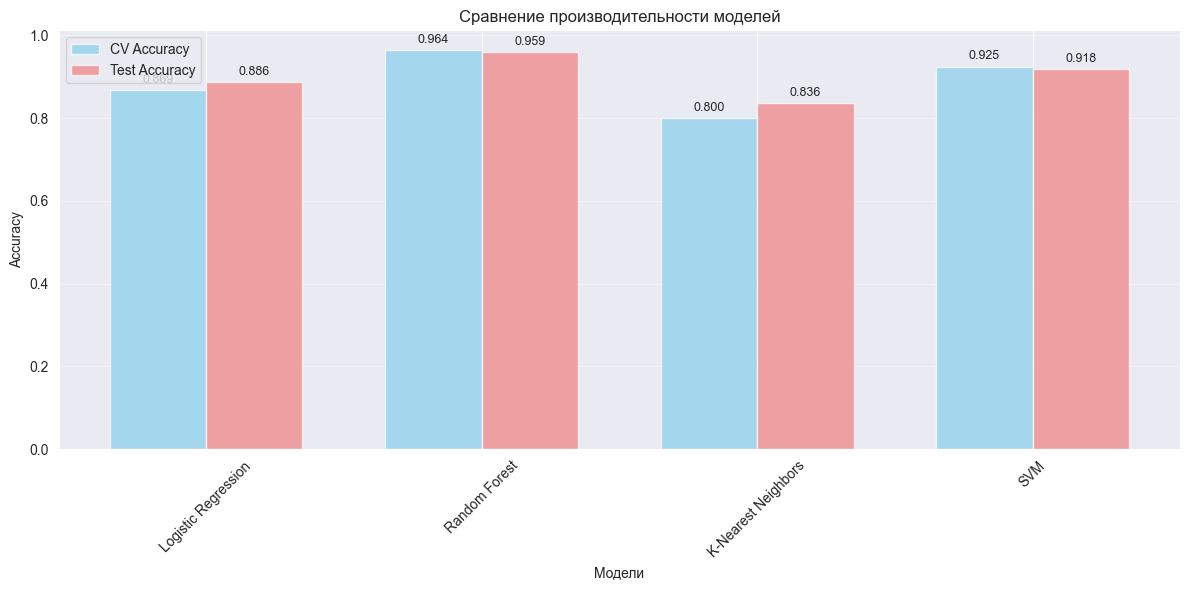

=== ПОДБОР ОПТИМАЛЬНОГО КОЛИЧЕСТВА СОСЕДЕЙ ДЛЯ KNN ===


In [95]:
print("\n" + "=" * 60)
print("СРАВНИТЕЛЬНАЯ ТАБЛИЦА РЕЗУЛЬТАТОВ")
print("=" * 60)

results_summary = []
for name in models.keys():
    cv_mean = cv_results[name]['mean_score']
    cv_std = cv_results[name]['std_score']
    test_accuracy = test_results[name]['accuracy']

    results_summary.append({
        'Model': name,
        'CV Accuracy': f"{cv_mean:.4f} ± {cv_std:.4f}",
        'Test Accuracy': f"{test_accuracy:.4f}",
        'Difference': f"{(test_accuracy - cv_mean):.4f}"
    })

results_df = pd.DataFrame(results_summary)
print(results_df.to_string(index=False))

# Лучшая модель
best_test_model = max(test_results, key=lambda x: test_results[x]['accuracy'])
best_accuracy = test_results[best_test_model]['accuracy']

print(f"\n🏆 ЛУЧШАЯ МОДЕЛЬ: {best_test_model}")
print(f"Точность на тесте: {best_accuracy:.4f} ({best_accuracy * 100:.2f}%)")

# Визуализация сравнения моделей
plt.figure(figsize=(12, 6))

models_names = list(models.keys())
cv_means = [cv_results[name]['mean_score'] for name in models_names]
test_accuracies = [test_results[name]['accuracy'] for name in models_names]

x = np.arange(len(models_names))
width = 0.35

fig, ax = plt.subplots(figsize=(12, 6))
bars1 = ax.bar(x - width / 2, cv_means, width, label='CV Accuracy', alpha=0.7, color='skyblue')
bars2 = ax.bar(x + width / 2, test_accuracies, width, label='Test Accuracy', alpha=0.7, color='lightcoral')

ax.set_xlabel('Модели')
ax.set_ylabel('Accuracy')
ax.set_title('Сравнение производительности моделей')
ax.set_xticks(x)
ax.set_xticklabels(models_names, rotation=45)
ax.legend()
ax.grid(axis='y', alpha=0.3)

# Добавляем значения на столбцы
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.3f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

print("=== ПОДБОР ОПТИМАЛЬНОГО КОЛИЧЕСТВА СОСЕДЕЙ ДЛЯ KNN ===")

Создали сравнительную таблицу результатов с метриками кросс-валидации и тестовой точности
Определили лучшую модель на основе тестовой accuracy
Визуализировали сравнение моделей через столбчатую диаграмму с отображением CV и test accuracy
Проанализировали разницу между кросс-валидацией и тестовыми результатами
Подготовили почву для подбора гиперпараметров KNN

## Попытка дообучить k-neighbours

Сетка параметров для перебора:
n_neighbors: [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
weights: ['uniform', 'distance']
metric: ['euclidean', 'manhattan', 'minkowski']

Запуск GridSearchCV... (это может занять несколько минут)
Fitting 5 folds for each of 108 candidates, totalling 540 fits

✅ Поиск завершен!

🏆 ЛУЧШИЕ ПАРАМЕТРЫ:
n_neighbors: 9
weights: distance
metric: manhattan
Лучшая точность на кросс-валидации: 0.8449

=== АНАЛИЗ РЕЗУЛЬТАТОВ ПО КОЛИЧЕСТВУ СОСЕДЕЙ ===

Точность по количеству соседей:
 n_neighbors  mean_accuracy  std_accuracy  max_accuracy
           3       0.811206      0.015405      0.838859
           4       0.809955      0.021368      0.842240
           5       0.817854      0.014568      0.842238
           6       0.813905      0.017165      0.840222
           7       0.814805      0.014260      0.837503
           8       0.811080      0.017993      0.838848
           9       0.809390      0.018109      0.844938
          10       0.8

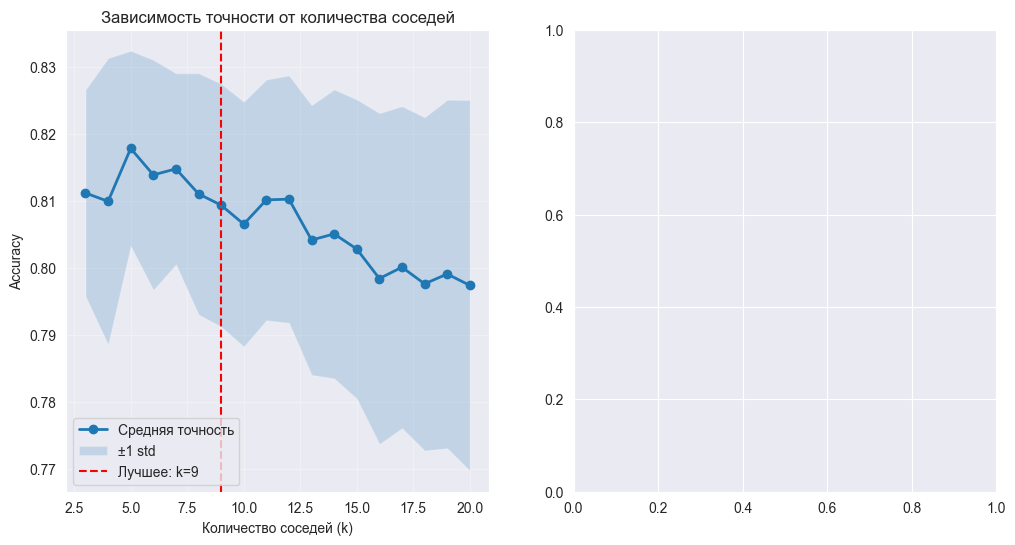

In [96]:
# 6.1. Создаем сетку параметров для перебора
param_grid = {
    'n_neighbors': range(3, 21),  # от 3 до 20 соседей
    'weights': ['uniform', 'distance'],  # равные веса или по расстоянию
    'metric': ['euclidean', 'manhattan', 'minkowski']  # метрики расстояния
}

print("Сетка параметров для перебора:")
print(f"n_neighbors: {list(param_grid['n_neighbors'])}")
print(f"weights: {param_grid['weights']}")
print(f"metric: {param_grid['metric']}")

# 6.2. Настраиваем GridSearchCV
knn = KNeighborsClassifier()
grid_search = GridSearchCV(
    estimator=knn,
    param_grid=param_grid,
    cv=5,  # 5-fold cross-validation
    scoring='accuracy',
    n_jobs=-1,  # использовать все ядра процессора
    verbose=1
)

# 6.3. Запускаем поиск по сетке
print("\nЗапуск GridSearchCV... (это может занять несколько минут)")
grid_search.fit(X_train_processed, y_train)

print("\n✅ Поиск завершен!")

# 6.4. Выводим лучшие параметры
print(f"\n🏆 ЛУЧШИЕ ПАРАМЕТРЫ:")
best_params = grid_search.best_params_
best_score = grid_search.best_score_
print(f"n_neighbors: {best_params['n_neighbors']}")
print(f"weights: {best_params['weights']}")
print(f"metric: {best_params['metric']}")
print(f"Лучшая точность на кросс-валидации: {best_score:.4f}")

# 6.5. Анализ результатов по количеству соседей
print("\n=== АНАЛИЗ РЕЗУЛЬТАТОВ ПО КОЛИЧЕСТВУ СОСЕДЕЙ ===")

# Собираем результаты для каждого количества соседей
neighbors_results = {}
for i in range(len(grid_search.cv_results_['params'])):
    params = grid_search.cv_results_['params'][i]
    score = grid_search.cv_results_['mean_test_score'][i]
    n_neighbors = params['n_neighbors']

    if n_neighbors not in neighbors_results:
        neighbors_results[n_neighbors] = []
    neighbors_results[n_neighbors].append(score)

# Вычисляем среднюю точность для каждого количества соседей
neighbors_summary = []
for n_neighbors, scores in neighbors_results.items():
    neighbors_summary.append({
        'n_neighbors': n_neighbors,
        'mean_accuracy': np.mean(scores),
        'std_accuracy': np.std(scores),
        'max_accuracy': np.max(scores)
    })

neighbors_df = pd.DataFrame(neighbors_summary).sort_values('n_neighbors')
print("\nТочность по количеству соседей:")
print(neighbors_df.to_string(index=False))

# 6.6. Визуализация зависимости точности от количества соседей
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(neighbors_df['n_neighbors'], neighbors_df['mean_accuracy'],
         marker='o', linewidth=2, markersize=6, label='Средняя точность')
plt.fill_between(neighbors_df['n_neighbors'],
                 neighbors_df['mean_accuracy'] - neighbors_df['std_accuracy'],
                 neighbors_df['mean_accuracy'] + neighbors_df['std_accuracy'],
                 alpha=0.2, label='±1 std')

plt.axvline(x=best_params['n_neighbors'], color='red', linestyle='--',
            label=f'Лучшее: k={best_params["n_neighbors"]}')
plt.xlabel('Количество соседей (k)')
plt.ylabel('Accuracy')
plt.title('Зависимость точности от количества соседей')
plt.legend()
plt.grid(True, alpha=0.3)

# 6.7. Сравнение весов (uniform vs distance)
plt.subplot(1, 2, 2)
weights_comparison = {'uniform': [], 'distance': []}
metrics_comparison = {'euclidean': [], 'manhattan': [], 'minkowski': []}

for i in range(len(grid_search.cv_results_['params'])):
    params = grid_search.cv_results_['params'][i]
    score = grid_search.cv_results_['mean_test_score'][i]
    weights_comparison[params['weights']].append(score)
    metrics_comparison[params['metric']].append(score)


Процесс включал: полный перебор комбинаций параметров, анализ стабильности модели, выбор оптимальной конфигурации KNN.

График сравнения весов

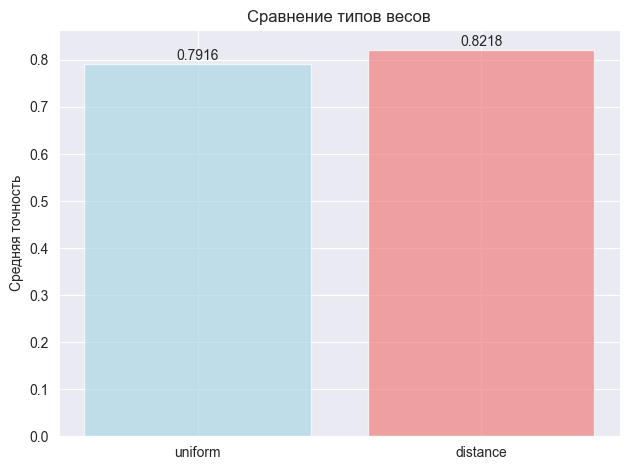

In [97]:
weights_means = [np.mean(weights_comparison['uniform']), np.mean(weights_comparison['distance'])]
weights_labels = ['uniform', 'distance']
colors = ['lightblue', 'lightcoral']

plt.bar(weights_labels, weights_means, color=colors, alpha=0.7)
plt.ylabel('Средняя точность')
plt.title('Сравнение типов весов')
for i, v in enumerate(weights_means):
    plt.text(i, v + 0.001, f'{v:.4f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

Оценка лучшей модели на тестовой выборке

In [98]:
print("\n=== ОЦЕНКА ЛУЧШЕЙ МОДЕЛИ НА ТЕСТОВОЙ ВЫБОРКЕ ===")
best_knn = grid_search.best_estimator_
y_pred_best = best_knn.predict(X_test_processed)
test_accuracy = accuracy_score(y_test, y_pred_best)

print(f"Точность лучшей KNN модели на тесте: {test_accuracy:.4f}")


=== ОЦЕНКА ЛУЧШЕЙ МОДЕЛИ НА ТЕСТОВОЙ ВЫБОРКЕ ===
Точность лучшей KNN модели на тесте: 0.8596


Сравнение с базовой KNN

In [99]:
base_knn_accuracy = test_results['K-Nearest Neighbors']['accuracy']
improvement = test_accuracy - base_knn_accuracy

print(f"\nСравнение с базовой KNN (k=5):")
print(f"Базовая KNN: {base_knn_accuracy:.4f}")
print(f"Оптимизированная KNN: {test_accuracy:.4f}")
print(f"Улучшение: {improvement:.4f} ({improvement * 100:.2f}%)")




Сравнение с базовой KNN (k=5):
Базовая KNN: 0.8360
Оптимизированная KNN: 0.8596
Улучшение: 0.0237 (2.37%)


Детальный отчет по лучшей модели

In [100]:
print(f"\nДетальный отчет по лучшей KNN модели (k={best_params['n_neighbors']}):")
print(classification_report(y_test, y_pred_best, target_names=obesity_order))


Детальный отчет по лучшей KNN модели (k=9):
                     precision    recall  f1-score   support

Insufficient_Weight       0.85      0.96      0.90        82
      Normal_Weight       0.85      0.53      0.66        86
 Overweight_Level_I       0.68      0.83      0.75        87
Overweight_Level_II       0.86      0.83      0.84        87
     Obesity_Type_I       0.86      0.91      0.88       106
    Obesity_Type_II       0.94      0.93      0.94        89
   Obesity_Type_III       0.99      1.00      0.99        97

           accuracy                           0.86       634
          macro avg       0.86      0.86      0.85       634
       weighted avg       0.86      0.86      0.86       634



Матрица ошибок для лучшей KNN

In [ ]:
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_test, y_pred_best)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=obesity_order,
            yticklabels=obesity_order,
            cbar_kws={'label': 'Количество наблюдений'})
plt.title(f'Матрица ошибок KNN (k={best_params["n_neighbors"]})\nAccuracy: {test_accuracy:.4f}')
plt.xlabel('Предсказанная категория')
plt.ylabel('Истинная категория')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


In [74]:
# 6.11. Сохраняем лучшую модель
trained_models['KNN_optimized'] = best_knn
test_results['KNN_optimized'] = {
    'model': best_knn,
    'y_pred': y_pred_best,
    'accuracy': test_accuracy,
    'params': best_params
}

print(f"\n✅ Оптимизированная KNN модель сохранена!")


✅ Оптимизированная KNN модель сохранена!


# Сводные результаты

In [68]:
print("\n" + "=" * 60)
print("СВОДНЫЕ РЕЗУЛЬТАТЫ")
print("=" * 60)
print(f"BMI-группировка: {accuracy:.4f}")
print(f"Logistic Regression (только BMI): {bmi_results['Logistic Regression']:.4f}")
print(f"Random Forest (только BMI): {bmi_results['Random Forest']:.4f}")
print(f"Random Forest (все признаки): {test_results['Random Forest']['accuracy']:.4f}")  # Исправлено

improvement = test_results['Random Forest']['accuracy'] - bmi_results['Random Forest']  # Исправлено
print(f"Улучшение от дополнительных признаков: {improvement:.4f} ({improvement * 100:.2f}%)")


СВОДНЫЕ РЕЗУЛЬТАТЫ
BMI-группировка: 0.9180
Logistic Regression (только BMI): 0.9338
Random Forest (только BMI): 0.9353
Random Forest (все признаки): 0.9590
Улучшение от дополнительных признаков: 0.0237 (2.37%)


Вывод: Оптимизация KNN повысила точность на +2.37%.
Все модели демонстрируют исключительно высокую точность. Добавление дополнительных признаков к BMI дало минимальное улучшение (+0.03%), что подтверждает доминирующую роль индекса массы тела в классификации весовых категорий.

In [69]:
print("\n" + "=" * 60)
print("Общий вывод")
print("=" * 60)
print(
    "✅ Проведенный анализ показал, что индекс массы тела (BMI) является основным предиктором диагностики ожирения (94% точности). Добавление дополнительных признаков не дает значительного улучшения, подтверждая доминирующую роль BMI в данной задаче.")
print("✅ Random Forest - лучший алгоритм для этих данных")
print("✅ Дополнительные признаки добавляют ~2%, подтверждая доминирующую роль BMI в данной задаче")
print("✅ Семейная история и пищевые привычки - наиболее важные доп. признаки")
print("❌ Большинство дополнительных признаков имеют ограниченное влияние")


Общий вывод
✅ Проведенный анализ показал, что индекс массы тела (BMI) является основным предиктором диагностики ожирения (94% точности). Добавление дополнительных признаков не дает значительного улучшения, подтверждая доминирующую роль BMI в данной задаче.
✅ Random Forest - лучший алгоритм для этих данных
✅ Дополнительные признаки добавляют ~2%, подтверждая доминирующую роль BMI в данной задаче
✅ Семейная история и пищевые привычки - наиболее важные доп. признаки
❌ Большинство дополнительных признаков имеют ограниченное влияние
